# Entrega 1 Grupo 4 Preparación de datos y limpieza

Proyecto: **¿Cuáles son los factores que influyen en la percepción de seguridad de los colombianos?**

## 1. Preparación de datos

### 1.1. Cargue de base de datos:
correspondiente a la encuesta "Percepción de seguridad y convivencia" de la Encuesta de Convivencia y Seguridad Ciudadana - ECSC - 2021 DANE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)


Cargue de bases de datos

In [2]:
#cargue de parámetros de variables a utilizar
diccionario_variables = pd.read_excel("../data/diccionario_filtrado.xlsx", sheet_name="variables")
diccionario_valores = pd.read_excel("../data/diccionario_filtrado.xlsx", sheet_name="valores")

In [3]:
#diccionario con descripción de variables
dict_desc = dict(zip(diccionario_variables['id_variable'],diccionario_variables['descripcion']))

In [4]:
#diccionario con significado de los valores de las variables con naturaleza discreta
dict_types = dict(zip(diccionario_variables['id_variable'],diccionario_variables['tipo']))
dict_values = {}
for var in set(diccionario_valores['id_variable']):
    dict_var = diccionario_valores[diccionario_valores['id_variable'] == var].copy()
    dict_var['valor'] = dict_var['valor'].astype(float).astype(str)
    dict_values[var] = dict(zip(dict_var['valor'],dict_var['descripcion_valor']))

In [5]:
# variables que serán utilizadas
vars_base = ["DIRECTORIO","SECUENCIA_ENCUESTA","SECUENCIA_P","ORDEN"]
variables = list(diccionario_variables['id_variable']) + vars_base

In [6]:
#cargue de bases de datos de la encuesta por aspectos:
df_ident = pd.read_csv("../data/Datos de la vivienda.CSV", sep=";").drop(columns=['SECUENCIA_ENCUESTA', 'SECUENCIA_P','ORDEN'])
df_carac = pd.read_csv("../data/Caracteristicas generales de las personas.CSV", sep=";")
df_carac2 = pd.read_csv("../data/Caracteristicas generales de las personas(cierre).CSV", sep=";")
df_percep_vbh = pd.read_csv("../data/Percepcion de seguridad en el barrio o vereda y en el hogar.CSV", sep=";").drop(columns=['SECUENCIA_P','ORDEN']).rename(columns={"SECUENCIA_ENCUESTA":"SECUENCIA_P"})
df_percep = pd.read_csv("../data/Percepcion de seguridad y convivencia.CSV", sep=";")
df_delitos = pd.read_csv("../data/Filtro de delitos.CSV", sep=";")
df_aporte_seg = pd.read_csv("../data/Percepcion del aporte a la seguridad.CSV", sep=";")

### 1.2. Unificación base de datos:
completitud de la encuesta "Percepción de seguridad y convivencia" de la Encuesta de Convivencia y Seguridad Ciudadana - ECSC - 2021 DANE por otros temas o aspectos.

In [7]:
# Realizamos filtros de solo las variables seleccionadas
df_ident = df_ident[[c for c in df_ident.columns if c in variables]]
df_carac = df_carac[[c for c in df_carac.columns if c in variables]]
df_carac2 = df_carac2[[c for c in df_carac2.columns if c in variables]]
df_percep_vbh = df_percep_vbh[[c for c in df_percep_vbh.columns if c in variables]]
df_percep = df_percep[[c for c in df_percep.columns if c in variables]]
df_delitos = df_delitos[[c for c in df_delitos.columns if c in variables]]
df_aporte_seg = df_aporte_seg[[c for c in df_aporte_seg.columns if c in variables]]

In [8]:
# Hacemos merge de todas las bases
df_base = df_carac.merge(df_ident, how="left")
df_base = df_base.merge(df_carac2, how="left")
df_base = df_base.merge(df_percep_vbh, how="left")
df_base = df_base.merge(df_percep, how="left")
df_base = df_base.merge(df_delitos, how="left")
df_base = df_base.merge(df_aporte_seg, how="left")

In [9]:
# Convertimos el floats las enteras, para poder cruzar con el diccionario
for v in df_base:
    if df_base[v].dtype == "int64":
        df_base[v] = df_base[v].astype(float)

In [10]:
# Aplicamos el tipo de datos configurado en el diccionario
df_base = df_base.astype(dict_types)

### 1.2. Análisis de calidad de datos:

In [11]:
# Descripción de la base de datos completa
print("Descripción de la base de datos:")
print("total registros:",  df_base.shape[0])
print("Número columnas:", df_base.shape[1])

Descripción de la base de datos:
total registros: 122251
Número columnas: 212


#### Análisis de municipios

In [12]:
#identificar municipios y ciudades de la encuesta
df_base[['DEPMUNI','CIUDADES28','Clase']].value_counts()

DEPMUNI  CIUDADES28  Clase               
0.0      0.0         Centro poblado y rur    16816
                     Cabecera                11338
8001.0   1.0         Cabecera                 8534
23001.0  1.0         Cabecera                 8147
13001.0  1.0         Cabecera                 8108
54001.0  1.0         Cabecera                 7156
50001.0  1.0         Cabecera                 6673
0.0      1.0         Cabecera                 6633
68001.0  1.0         Cabecera                 6470
73001.0  1.0         Cabecera                 6396
11001.0  1.0         Cabecera                 6328
5001.0   1.0         Cabecera                 6151
66001.0  1.0         Cabecera                 6135
76001.0  1.0         Cabecera                 5896
17001.0  1.0         Cabecera                 5853
52001.0  1.0         Cabecera                 5617
dtype: int64

Se identifica que la mayoría que en la variable DEPMUNI y CIUDADES28 tienen valor de cero, corresponden a Centro pablado y rural, por tal motivo unificamos estas variables, con el fin de dejar un municipio con esta categoría y el resto se marcarán como desconocidos.

In [13]:
df_base['DEPMUNI'] = df_base.apply(lambda r: "-1.0" if r["Clase"] == "Centro poblado y rur" else r['DEPMUNI'],axis=1)

#### Análisis de edad

Se identifican endades dentro de los rangos normales. Las edades 0 corresponden a recién nacidos y es normal que hayan personas de poca edad, ya que la encuesta caracteriza a todas las personas que conforman el hogar.

In [14]:
df_base['P5785'].describe()

count    122251.000000
mean         35.610752
std          21.815873
min           0.000000
25%          17.000000
50%          33.000000
75%          52.000000
max         104.000000
Name: P5785, dtype: float64

no se identifica faltantes por edad

In [15]:
df_base['P5785'].isna().sum()

0

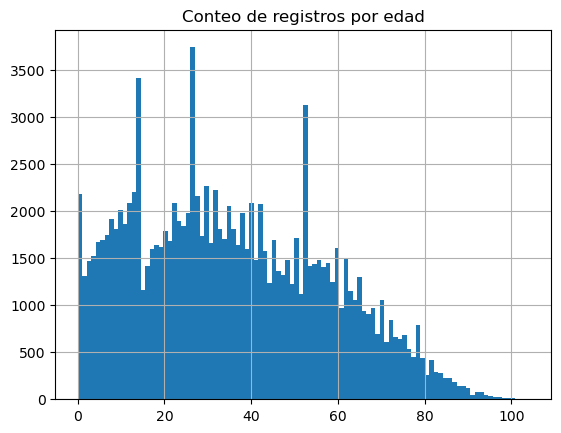

In [16]:
df_base['P5785'].hist(bins=100)
plt.title("Conteo de registros por edad")
plt.show()

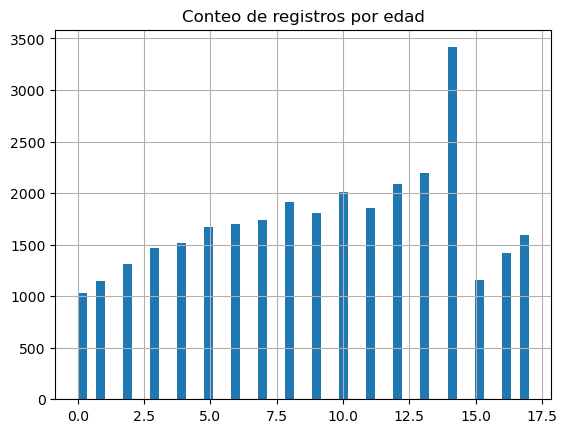

In [17]:
df_base[df_base['P5785'] < 18]['P5785'].hist(bins=50)
plt.title("Conteo de registros por edad")
plt.show()

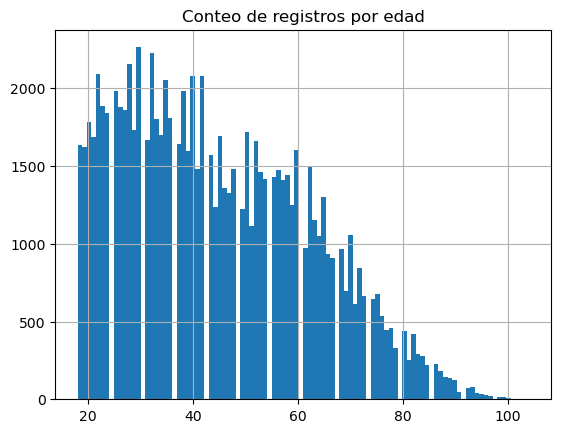

In [18]:
df_base[df_base['P5785'] >= 18]['P5785'].hist(bins=100)
plt.title("Conteo de registros por edad")
plt.show()

Para el estudio nos enfocaremos en población mayor de 18 años

In [19]:
df_base = df_base[df_base['P5785'] >= 18]

### 1.3. Análisis de calidad de datos por grupos de variables

In [20]:
#funciones analisis exploratorio
def vis_categorica(datos, var, hue=None):
    # Visualización de variable categórica
    values = datos[var].fillna("MISSING")
    counts = values.value_counts()

    fig, ax = plt.subplots(figsize=(5, 0.5*len(counts)))
    sns.countplot(data=datos.fillna("MISSING"), y = var, hue=hue, order = counts.index, ax=ax)

    label_len = max([len(str(c)) for c in counts.index])

    if(label_len < 5):
        plt.xticks(rotation=0)
    elif(label_len>=5 and label_len<12):
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=90)

    if(hue is None):
        ax.bar_label(ax.containers[0], labels=[f"{round(v,3)}%" for v in counts/len(values)*100])

    ax.set_xlabel('Conteo')
    ax.set_ylabel(var)
    ax.set_title(f'Conteo por {var}')

    plt.show()

def vis_numerica(datos, var, hue=None):
    # Visualización de variable numérica
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    sns.kdeplot(data=datos, x=var, hue=hue, ax=ax1)
    sns.boxplot(data=datos, y=var, x=hue, ax=ax2, showfliers=True)

    ax1.set_title(f'Histograma {var}')
    ax1.set_xlabel(var)

    ax2.set_title(f'Boxplot {var}')

    plt.show()
    
def descriptivo_grupo(df_base, grupo):    
    for var in grupo:
        var_desc = dict_desc.get(var,"")
        display(HTML(f"<h3>Análisis variable: {var}</h3>"))
        display(HTML(f"<b>Descripción:</b> {var_desc}"))
        display(HTML("<h4>Estadísticas descriptivas:</h4>"))
        print(df_base[var].describe())
        display(HTML("<h4>Gráficos de distribución:</h4>"))
        if df_base[var].dtype == 'string' or df_base[var].dtype == 'O':
            if dict_values.get(var,None) is not None:
                var_data = pd.DataFrame(df_base[var].map(dict_values.get(var)))
                vis_categorica(var_data, var)
            else:
                vis_categorica(df_base, var)
        else:
            vis_numerica(df_base, var)

Agrupación de variables por diferentes aspectos o preguntas de la encuesta

In [21]:
vars_problema_barrio = ['P1398S1','P1398S2','P1398S3','P1398S4','P1398S5','P1398S6','P1398S8','P1398S9','P1398S10','P1398S12','P1398S11','P1398S13','P1398S14','P1398S15','P1398S16','P1398S17','P1398S18','P1398S19','P1398S20','P1398S21','P1398S22']
vars_presen_grupos = ['P1590S1','P1590S2','P1590S3','P1590S4','P1590S5']
vars_inseguro_barrio = ['P1361S1','P1361S15','P1361S14','P1361S2','P1361S16','P1361S3','P1361S4','P1361S5','P1361S6','P1361S7','P1361S11','P1361S8','P1361S9','P1361S10','P1361S12','P1361S13']
vars_inseguro_ciudad = ['P1358S1','P1358S14','P1358S13','P1358S2','P1358S15','P1358S3','P1358S4','P1358S5','P1358S6','P1358S7','P1358S12','P1358S8','P1358S9','P1358S11','P1358S10']
vars_sera_victima = ['P3109S1','P3109S2','P3109S3','P3109S4','P3109S5','P3109S6','P3109S7','P3109S16','P3109S17','P3109S9','P3109S10','P3109S11','P3109S12','P3109S13','P3109S18','P3109S14']
vars_tomo_medidas = ['P3112S1','P3112S2','P3112S3','P3112S4','P3112S5','P3112S6','P3112S7','P3112S8','P3112S9','P3112S10','P3112S11','P3112S12','P3112S13','P3112S14']
vars_ha_expe_incomoda = ['P3302S1','P3302S2','P3302S3','P3302S4','P3302S5','P3302S6','P3302S7','P3302S8']
vars_mejoraria = ['P3316S1','P3316S2','P3316S3','P3316S4','P3316S5','P3316S6','P3316S7','P3316S8','P3316S9','P3316S10','P3316S11','P3316S12']
vars_ha_expe_situa = ['P3306','P3307','P3308','P3309','P33010','P33011','P3312']
vars_sufrio_agresion = ['P3115S1','P3115S2','P3115S3']
vars_sufrio_delito = ['P1976S1','P1976S2','P1976S9','P1976S4','P1976S5','P1976S6','P1976S7','P1976S13','P1976S14','P1976S8']
vars_sufrido_delito2 = ['P3315','P541','P1392','P1959','P1960','P525','P1343','P526','P1315','P528','P1286','P1956']
vars_propietario_vehi = ['P565S1','P565S2','P565S3','P565S4']
vars_percep = ['P3108',"P3113S1","P3113S3","P3113S4","P3113S5","P3113S6","P3113S7","P3113S8","P3113S9","P3113S10","P3113S20","P3113S21","P3113S22"]
vars_justi_violen = ["P1353S1","P1353S2","P1353S3","P1353S4","P1353S5","P1353S6"]
vars_limit_fisica = ["P1906S1","P1906S2","P1906S3","P1906S4","P1906S5","P1906S6","P1906S7","P1906S8","P1906S9"]
vars_segu_lugares = ['P3111S1','P3111S2','P3111S3','P3111S4','P3111S5','P3111S6','P3111S8','P3111S9']
vars_institu = ['P1612S1','P1182S1','P1182S2','P1182S3','P1181S1','P1181S2','P3317S1','P3317S2','P3317S3','P3321','P3119','P3127']
vars_siente = ['P3105','P3106','P3502','P3107','P564','P3114']
vars_generales = ['P220','P5785','DEPMUNI','P1987','P1988S1','P1989','P6210','P1366','P1115']
vars_total = vars_problema_barrio+vars_presen_grupos+vars_inseguro_barrio+vars_inseguro_ciudad+vars_sera_victima+vars_tomo_medidas+vars_ha_expe_incomoda+vars_mejoraria+vars_ha_expe_situa+vars_sufrio_agresion+vars_sufrio_delito+vars_sufrido_delito2+vars_propietario_vehi+vars_percep+vars_justi_violen+vars_limit_fisica+vars_segu_lugares+vars_institu+vars_siente+vars_generales

In [22]:
vars_naturaleza = {}
vars_naturaleza['vars_discretas'] = []
vars_naturaleza['vars_binarias'] = []
vars_naturaleza['vars_numericas'] = []
vars_naturaleza['vars_ordinales'] = []
vars_naturaleza['vars_agrupadas'] = []

count     91222
unique        2
top         2.0
freq      49675
Name: P220, dtype: object


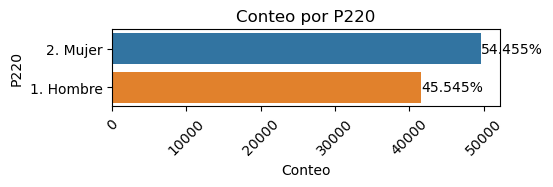

count    91222.000000
mean        44.593541
std         17.662937
min         18.000000
25%         30.000000
50%         42.000000
75%         58.000000
max        104.000000
Name: P5785, dtype: float64


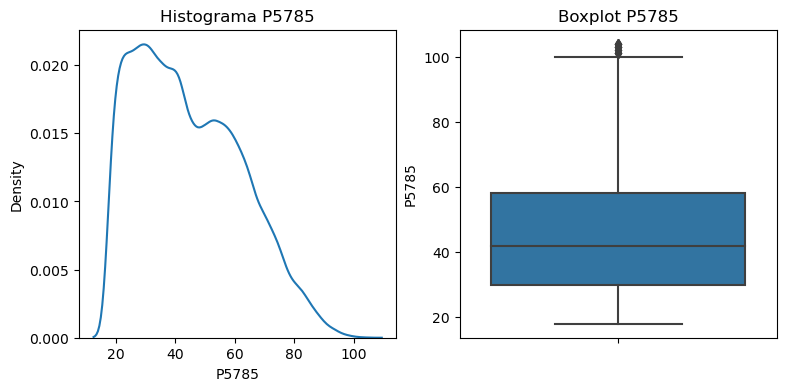

count     91222
unique       15
top         0.0
freq      13027
Name: DEPMUNI, dtype: object


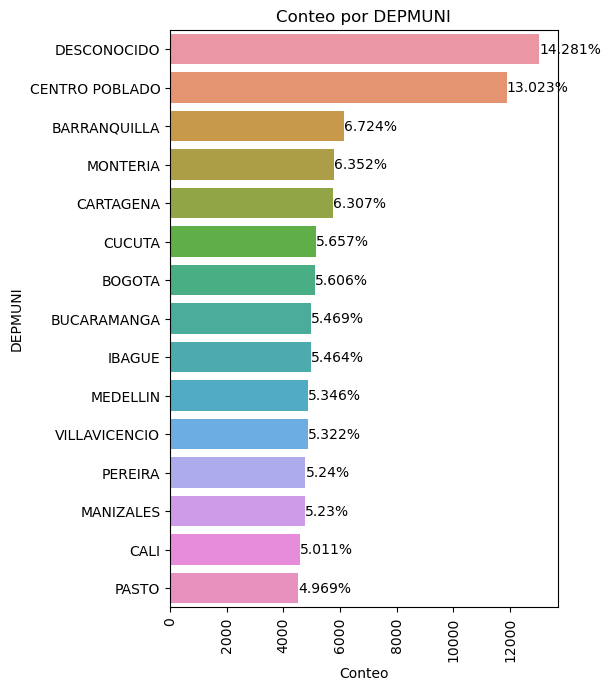

count     91222
unique        5
top         1.0
freq      51587
Name: P1987, dtype: object


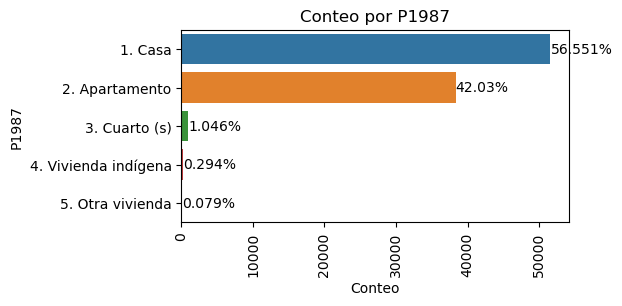

count     90615
unique        8
top         1.0
freq      30258
Name: P1988S1, dtype: object


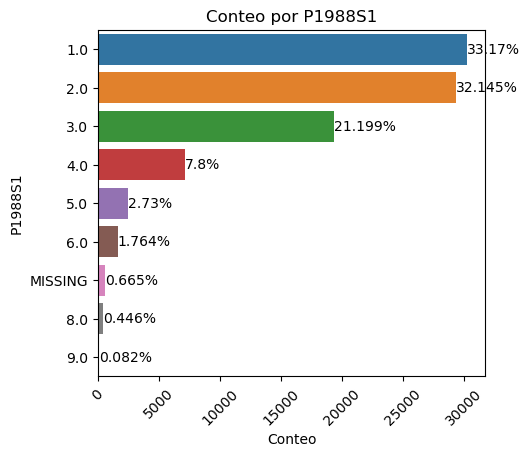

count     91222
unique        4
top         1.0
freq      49839
Name: P1989, dtype: object


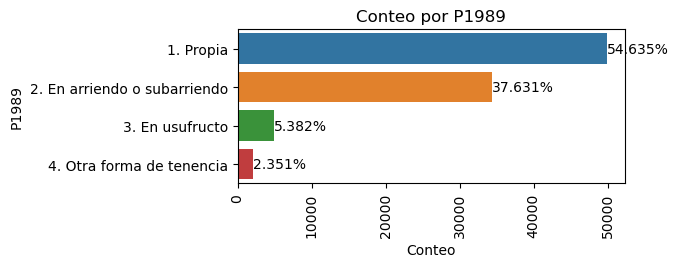

count     91222
unique        7
top         5.0
freq      31993
Name: P6210, dtype: object


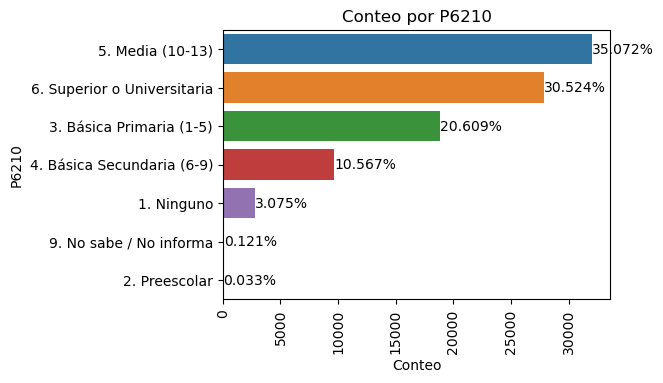

count     91222
unique        6
top         6.0
freq      27945
Name: P1366, dtype: object


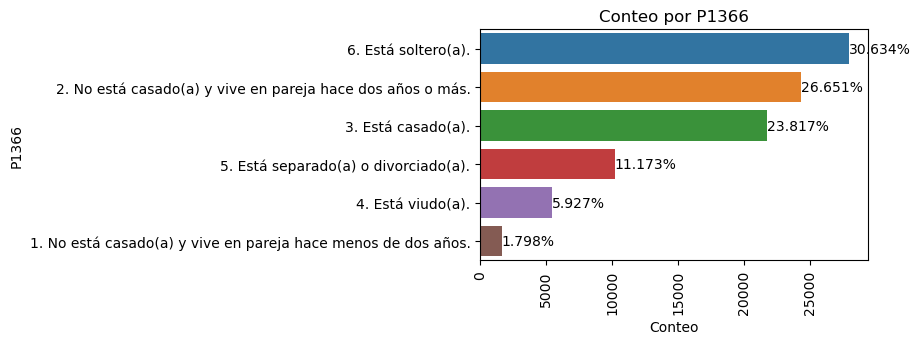

count     91222
unique        4
top         2.0
freq      66029
Name: P1115, dtype: object


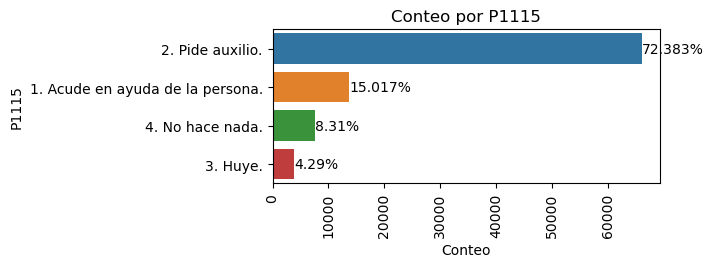

In [23]:
display(HTML(f"<h2>Análisis para grupo de variables generales</h2>"))
descriptivo_grupo(df_base,vars_generales)

De acuerdo a los valores de cada variable, se definieron qué variables serán numéricas, discretas u ordinales. Se asignan los valores correspondientes a las variables discretas.

In [24]:
vars_naturaleza['vars_numericas'].extend(["P5785","P1988S1"])
vars_naturaleza['vars_discretas'].extend(["DEPMUNI","P1987","P1989","P1366","P1115"])
vars_naturaleza['vars_binarias'].extend(["P220"])
vars_naturaleza['vars_ordinales'].extend(["P6210"])

In [25]:
df_base["P1988S1"] = df_base["P1988S1"].astype(float).fillna(df_base["P1988S1"].astype(float).mean().round())

In [26]:
dict_DEPMUNI = {'0.0':'DESCONOCIDO',
                '8001.0': 'BARRANQUILLA',
                '23001.0': 'MONTERIA',
                '13001.0': 'CARTAGENA',
                '54001.0': 'CUCUTA',
                '11001.0': 'BOGOTA',
                '68001.0': 'BUCARAMANGA',
                '73001.0': 'IBAGUE',
                '5001.0': 'MEDELLIN',
                '50001.0': 'VILLAVICENCIO',
                '66001.0': 'PEREIRA',
                '17001.0': 'MANIZALES',
                '76001.0': 'CALI',
                '52001.0': 'PASTO',
                '-1.0': 'CENTRO POBLADO'}

df_base['DEPMUNI'] = df_base['DEPMUNI'].map(dict_DEPMUNI)

In [27]:
dict_P1987 = {'1.0': 'Casa',
              '2.0': 'Apartamento',
              '3.0': 'Cuarto (s)',
              '4.0': 'Vivienda indígena',
              '5.0': 'Otra vivienda'}

df_base['P1987'] = df_base['P1987'].map(dict_P1987)

In [28]:
dict_P1989 = {'1.0': 'Propia',
              '2.0': 'En arriendo o subarriendo',
              '3.0': 'En usufructo',
              '4.0': 'Otra forma de tenencia'}

df_base['P1989'] = df_base['P1989'].map(dict_P1989)

In [29]:
dict_P1366 = {'1.0': 'No casado(a) vive pareja menos dos años',
              '2.0': 'No casado(a) vive pareja dos años o más',
              '3.0': 'Está casado(a)',
              '4.0': 'Está viudo(a)',
              '5.0': 'Está separado(a) o divorciado(a)',
              '6.0': 'Está soltero(a)'}

df_base['P1366'] = df_base['P1366'].map(dict_P1366)

In [30]:
dict_P1115 = {'1.0': 'Acude en ayuda de la persona',
              '2.0': 'Pide auxilio',
              '3.0': 'Huye',
              '4.0': 'No hace nada'}

df_base['P1115'] = df_base['P1115'].map(dict_P1115)

In [31]:
dict_P220 = {'1.0': 'Hombre', '2.0': 'Mujer'}

df_base['P220'] = df_base['P220'].map(dict_P220)

count     91222
unique        4
top         4.0
freq      87255
Name: P1906S1, dtype: object


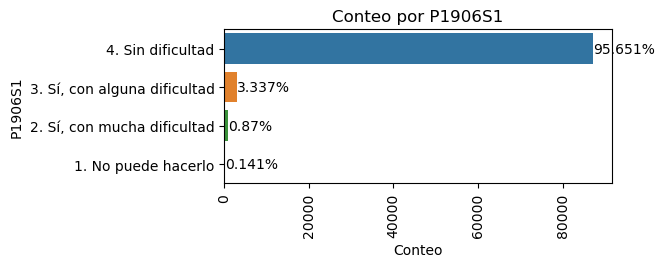

count     91222
unique        4
top         4.0
freq      89189
Name: P1906S2, dtype: object


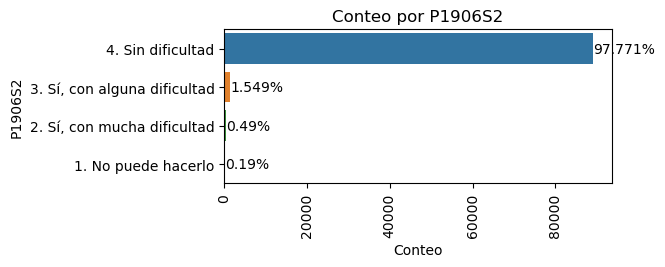

count     91222
unique        4
top         4.0
freq      73478
Name: P1906S3, dtype: object


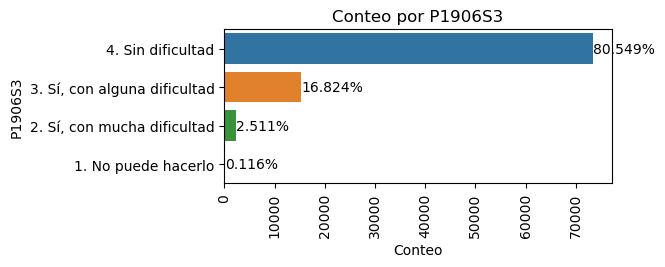

count     91222
unique        4
top         4.0
freq      83890
Name: P1906S4, dtype: object


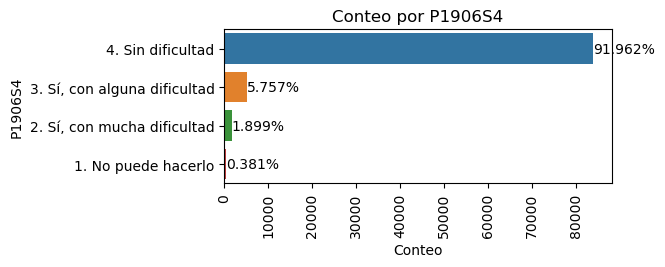

count     91222
unique        4
top         4.0
freq      87694
Name: P1906S5, dtype: object


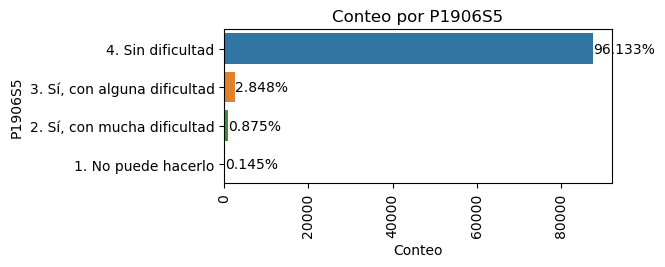

count     91222
unique        4
top         4.0
freq      88616
Name: P1906S6, dtype: object


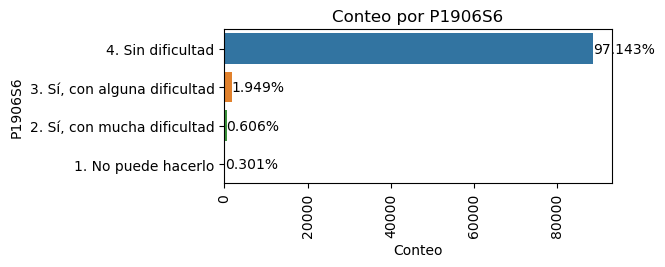

count     91222
unique        4
top         4.0
freq      88919
Name: P1906S7, dtype: object


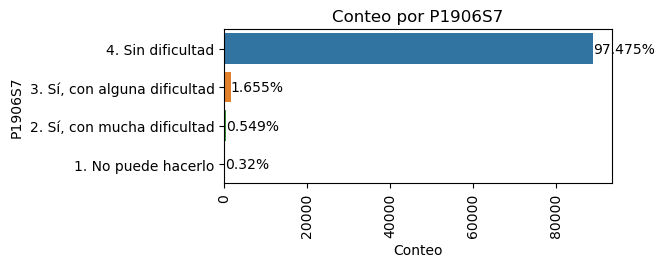

count     91222
unique        4
top         4.0
freq      89529
Name: P1906S8, dtype: object


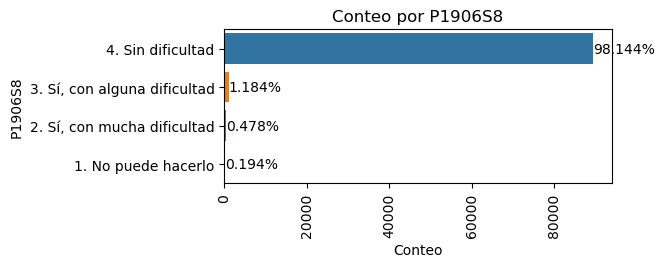

count     91222
unique        4
top         4.0
freq      87707
Name: P1906S9, dtype: object


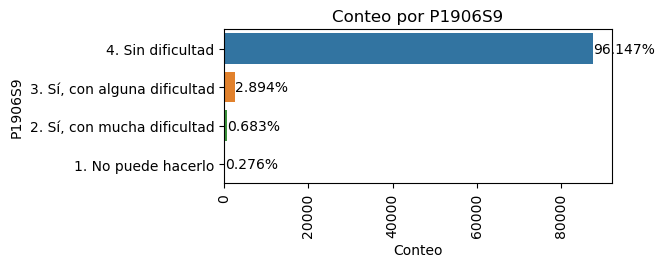

In [32]:
display(HTML(f"<h2>Análisis para grupo de variables \"limitaciones físicas\"</h2>"))
descriptivo_grupo(df_base,vars_limit_fisica)

De acuerdo a los valores de cada variable, se definieron que todas la variables de este grupo se tratarán como ordinales

In [33]:
df_base[vars_limit_fisica] = df_base[vars_limit_fisica].astype(float)
vars_naturaleza['vars_ordinales'].extend(vars_limit_fisica)

count     91222
unique        2
top         2.0
freq      82155
Name: P565S1, dtype: object


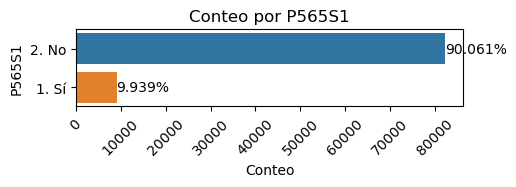

count     91222
unique        2
top         2.0
freq      80036
Name: P565S2, dtype: object


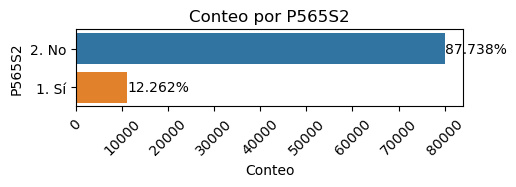

count     91222
unique        2
top         2.0
freq      87616
Name: P565S3, dtype: object


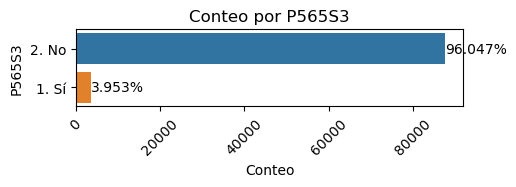

count     91222
unique        2
top         2.0
freq      91178
Name: P565S4, dtype: object


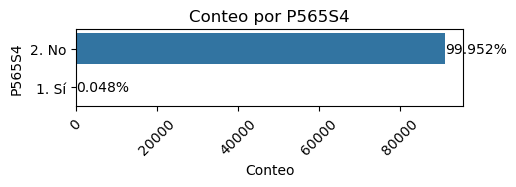

In [34]:
display(HTML(f"<h2>Análisis para grupo de variables \"propietario de vehículo\"</h2>"))
descriptivo_grupo(df_base,vars_propietario_vehi)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [35]:
vars_naturaleza['vars_agrupadas'].extend(vars_propietario_vehi)
df_base['propietario_vehi'] = df_base[vars_propietario_vehi].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_propietario_vehi] = df_base[vars_propietario_vehi].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["propietario_vehi"])
vars_naturaleza['vars_binarias'].extend(vars_propietario_vehi)

count     91222
unique        2
top         2.0
freq      90740
Name: P3115S1, dtype: object


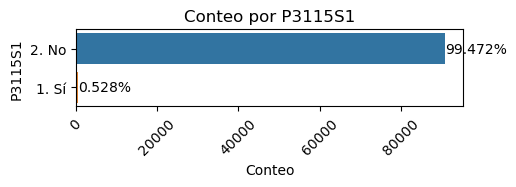

count     91222
unique        2
top         2.0
freq      90823
Name: P3115S2, dtype: object


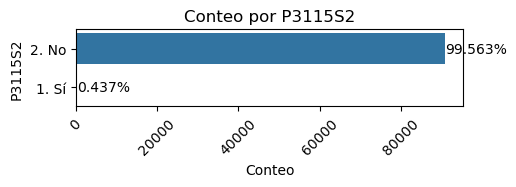

count     91222
unique        2
top         2.0
freq      91058
Name: P3115S3, dtype: object


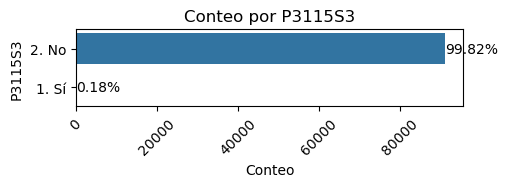

In [36]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha sufrido agresión\"</h2>"))
descriptivo_grupo(df_base,vars_sufrio_agresion)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [37]:
vars_naturaleza['vars_agrupadas'].extend(vars_sufrio_agresion)
df_base['sufrio_agresion'] = df_base[vars_sufrio_agresion].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_sufrio_agresion] = df_base[vars_sufrio_agresion].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["sufrio_agresion"])
vars_naturaleza['vars_binarias'].extend(vars_sufrio_agresion)

count     91222
unique        2
top         2.0
freq      90826
Name: P1976S1, dtype: object


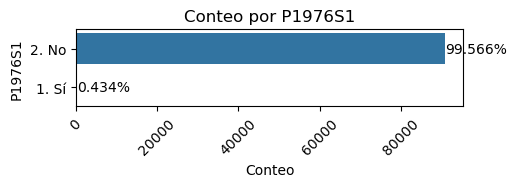

count     91222
unique        2
top         2.0
freq      90942
Name: P1976S2, dtype: object


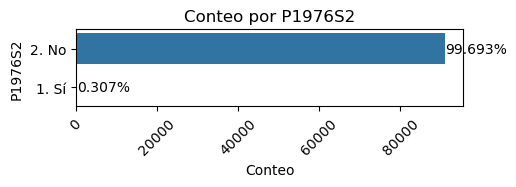

count     91222
unique        2
top         2.0
freq      91059
Name: P1976S9, dtype: object


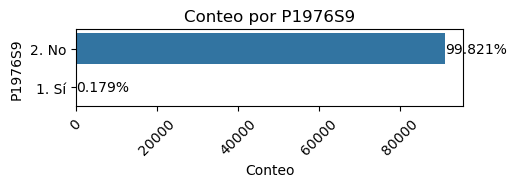

count     91222
unique        2
top         2.0
freq      91191
Name: P1976S4, dtype: object


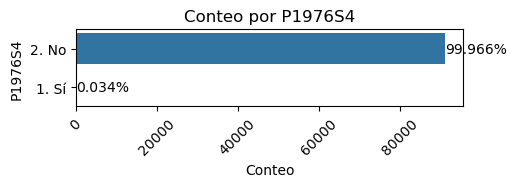

count     91222
unique        2
top         2.0
freq      91203
Name: P1976S5, dtype: object


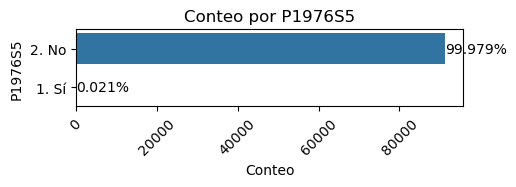

count     91222
unique        2
top         2.0
freq      91204
Name: P1976S6, dtype: object


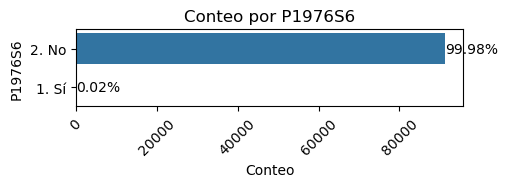

count     91222
unique        2
top         2.0
freq      91145
Name: P1976S7, dtype: object


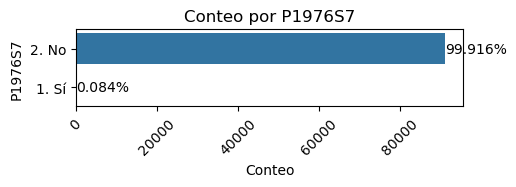

count     91222
unique        2
top         2.0
freq      90163
Name: P1976S13, dtype: object


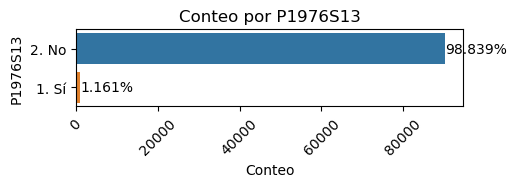

count     91222
unique        2
top         2.0
freq      91190
Name: P1976S14, dtype: object


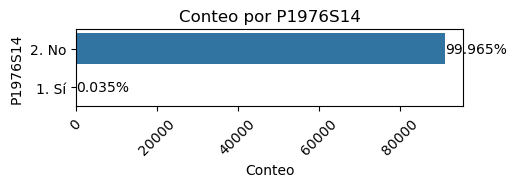

count     91222
unique        2
top         2.0
freq      91184
Name: P1976S8, dtype: object


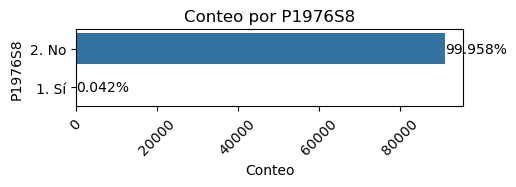

In [38]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha sufrido delito\"</h2>"))
descriptivo_grupo(df_base,vars_sufrio_delito)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [39]:
vars_naturaleza['vars_agrupadas'].extend(vars_sufrio_delito)
df_base['sufrio_delito'] = df_base[vars_sufrio_delito].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_sufrio_delito] = df_base[vars_sufrio_delito].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["sufrio_delito"])
vars_naturaleza['vars_binarias'].extend(vars_sufrio_delito)

count     91222
unique        3
top         2.0
freq      87655
Name: P3315, dtype: object


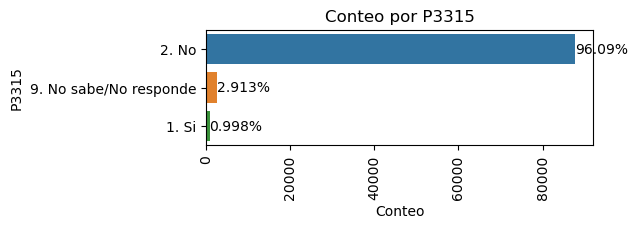

count     41542
unique        2
top         2.0
freq      40641
Name: P541, dtype: object


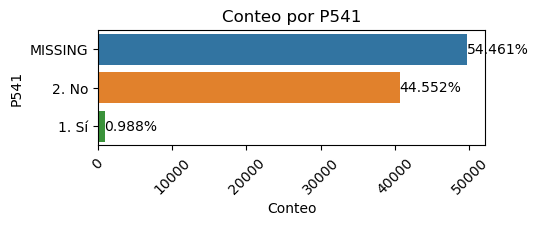

count     41542
unique        2
top         2.0
freq      40905
Name: P1392, dtype: object


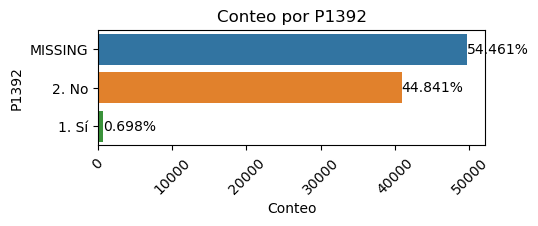

count     41542
unique        2
top         2.0
freq      41331
Name: P1959, dtype: object


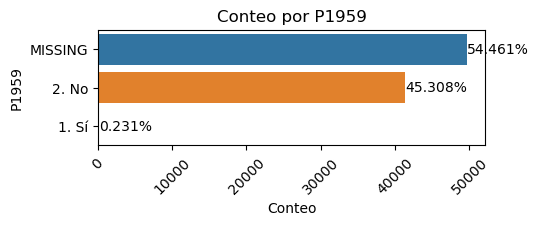

count     41542
unique        2
top         2.0
freq      41422
Name: P1960, dtype: object


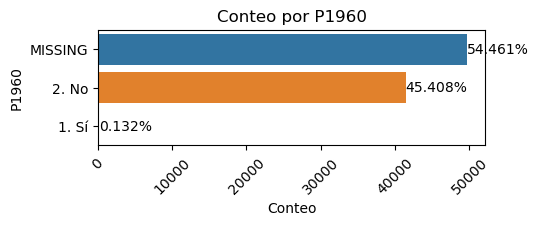

count     91222
unique        2
top         2.0
freq      87891
Name: P525, dtype: object


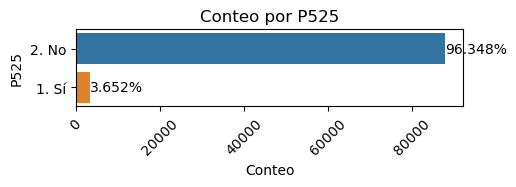

count     91222
unique        2
top         2.0
freq      88201
Name: P1343, dtype: object


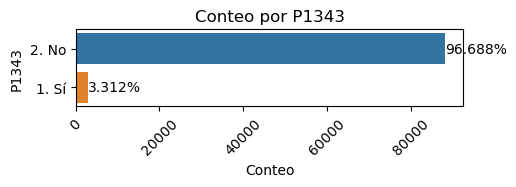

count     91222
unique        2
top         2.0
freq      90554
Name: P526, dtype: object


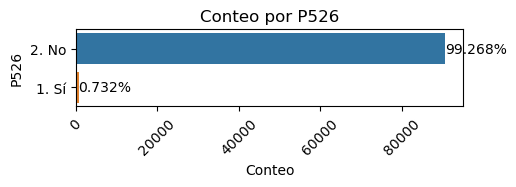

count     91222
unique        2
top         2.0
freq      90817
Name: P1315, dtype: object


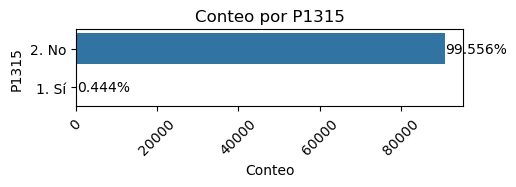

count     91222
unique        2
top         2.0
freq      89172
Name: P528, dtype: object


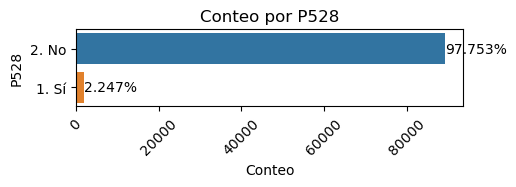

count     91222
unique        2
top         2.0
freq      90260
Name: P1286, dtype: object


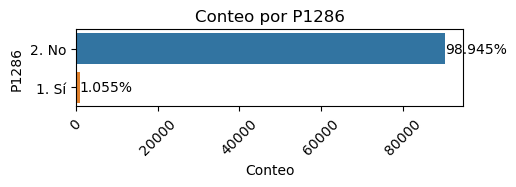

count     91222
unique        2
top         2.0
freq      90661
Name: P1956, dtype: object


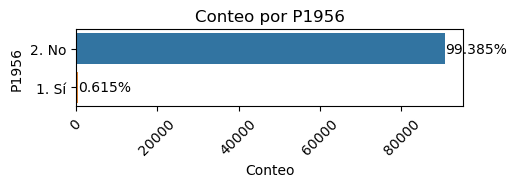

In [40]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha sufrido delito general\"</h2>"))
descriptivo_grupo(df_base,vars_sufrido_delito2)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [41]:
vars_naturaleza['vars_agrupadas'].extend(vars_sufrido_delito2)
df_base['sufrido_delito2'] = df_base[vars_sufrido_delito2].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_sufrido_delito2] = df_base[vars_sufrido_delito2].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["sufrido_delito2"])
vars_naturaleza['vars_binarias'].extend(vars_sufrido_delito2)

count     91222
unique        2
top         1.0
freq      51384
Name: P1398S1, dtype: object


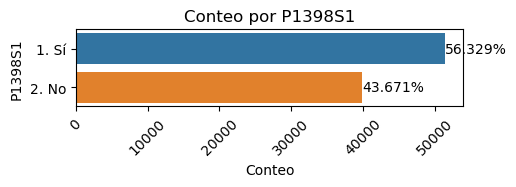

count     91222
unique        2
top         2.0
freq      62036
Name: P1398S2, dtype: object


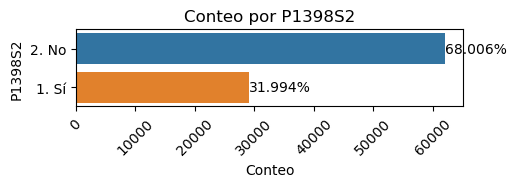

count     91222
unique        2
top         2.0
freq      71520
Name: P1398S3, dtype: object


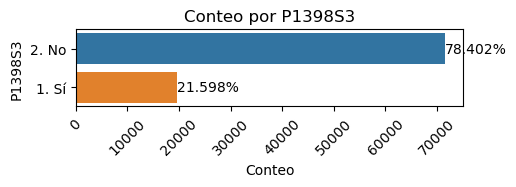

count     91222
unique        2
top         2.0
freq      69450
Name: P1398S4, dtype: object


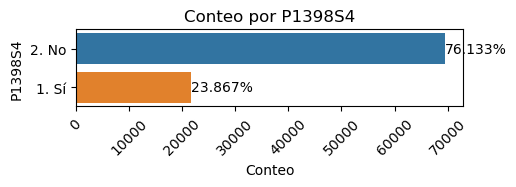

count     91222
unique        2
top         2.0
freq      76653
Name: P1398S5, dtype: object


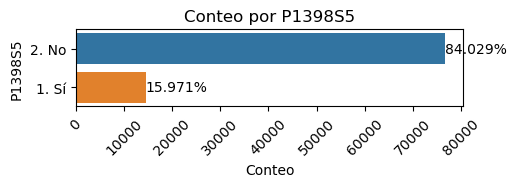

count     91222
unique        2
top         2.0
freq      82848
Name: P1398S6, dtype: object


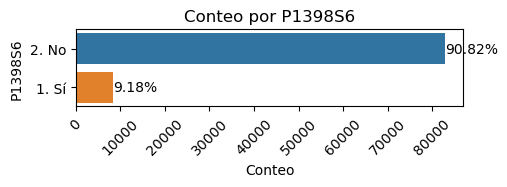

count     91222
unique        2
top         2.0
freq      60274
Name: P1398S8, dtype: object


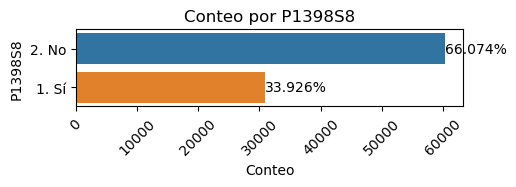

count     91222
unique        2
top         2.0
freq      75204
Name: P1398S9, dtype: object


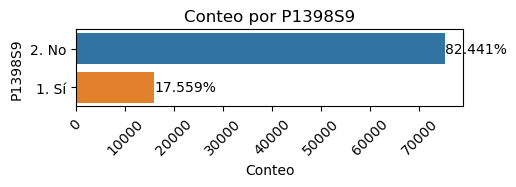

count     91222
unique        2
top         1.0
freq      47538
Name: P1398S10, dtype: object


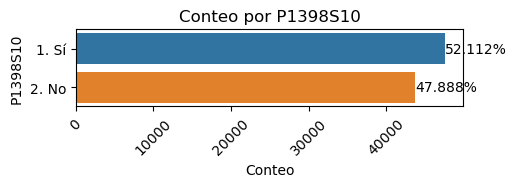

count     91222
unique        2
top         1.0
freq      46887
Name: P1398S12, dtype: object


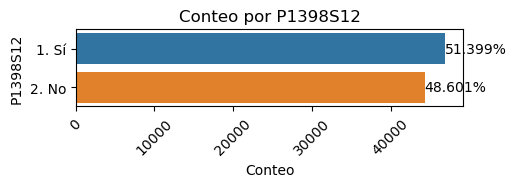

count     91222
unique        2
top         2.0
freq      90173
Name: P1398S11, dtype: object


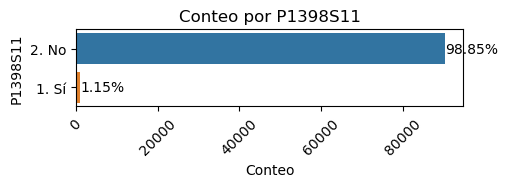

count     11880
unique        2
top         2.0
freq      10836
Name: P1398S13, dtype: object


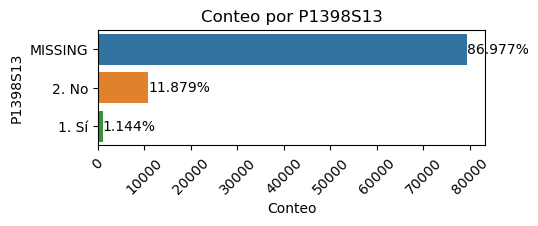

count     11880
unique        2
top         2.0
freq      11727
Name: P1398S14, dtype: object


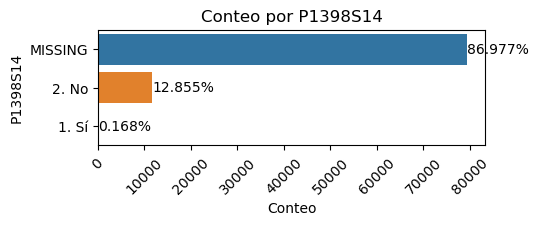

count     11880
unique        2
top         2.0
freq      11677
Name: P1398S15, dtype: object


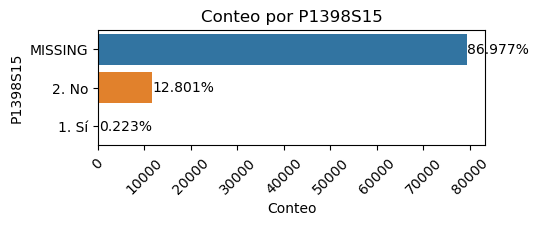

count     11880
unique        2
top         2.0
freq      11743
Name: P1398S16, dtype: object


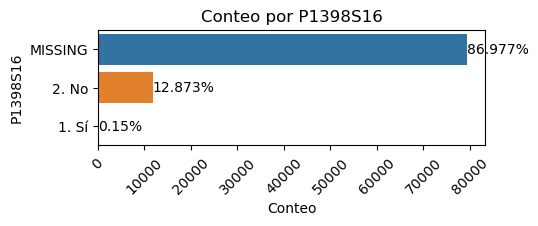

count     91222
unique        2
top         2.0
freq      89980
Name: P1398S17, dtype: object


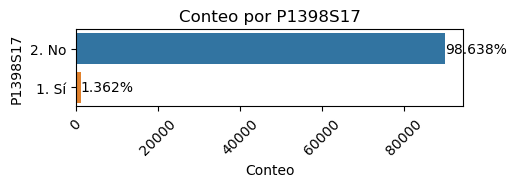

count     91222
unique        2
top         2.0
freq      90797
Name: P1398S18, dtype: object


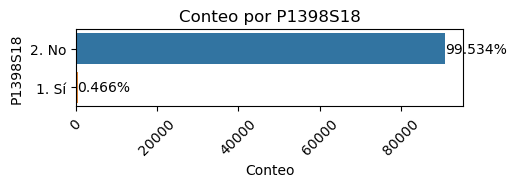

count     91222
unique        2
top         2.0
freq      88774
Name: P1398S19, dtype: object


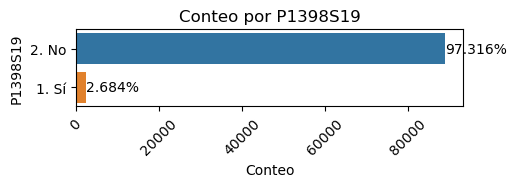

count     91222
unique        2
top         2.0
freq      77632
Name: P1398S20, dtype: object


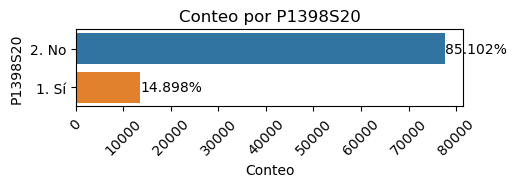

count     91222
unique        2
top         2.0
freq      90030
Name: P1398S21, dtype: object


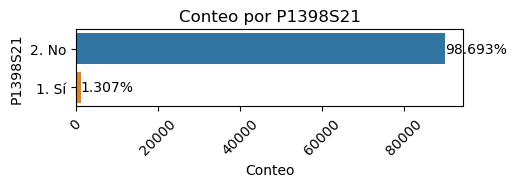

count     91222
unique        2
top         2.0
freq      87751
Name: P1398S22, dtype: object


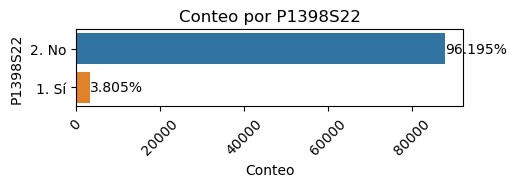

In [42]:
display(HTML(f"<h2>Análisis para grupo de variables \"problemas en barrio\"</h2>"))
descriptivo_grupo(df_base,vars_problema_barrio)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [43]:
vars_naturaleza['vars_agrupadas'].extend(vars_problema_barrio)
df_base['problema_barrio'] = df_base[vars_problema_barrio].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_problema_barrio] = df_base[vars_problema_barrio].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["problema_barrio"])
vars_naturaleza['vars_binarias'].extend(vars_problema_barrio)

count     91222
unique        2
top         2.0
freq      67069
Name: P1590S1, dtype: object


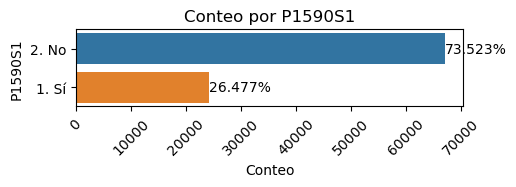

count     91222
unique        2
top         2.0
freq      65680
Name: P1590S2, dtype: object


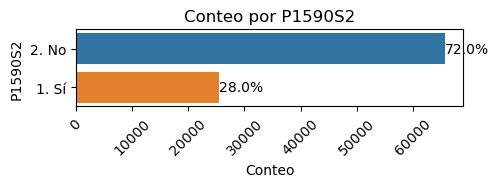

count     84561
unique        2
top         2.0
freq      80404
Name: P1590S3, dtype: object


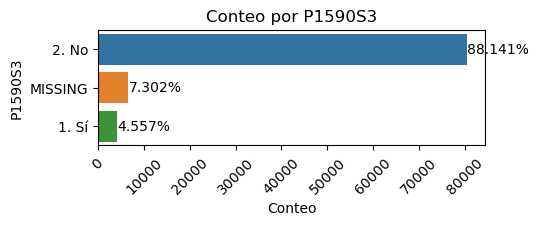

count     91222
unique        2
top         2.0
freq      90194
Name: P1590S4, dtype: object


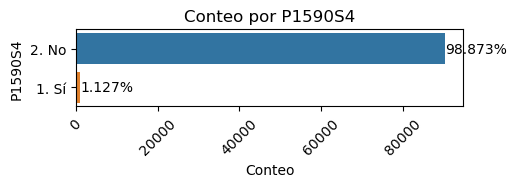

count     91222
unique        2
top         2.0
freq      88241
Name: P1590S5, dtype: object


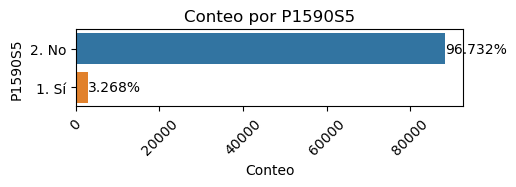

In [44]:
display(HTML(f"<h2>Análisis para grupo de variables \"presencia grupos en barrio\"</h2>"))
descriptivo_grupo(df_base,vars_presen_grupos)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [45]:
vars_naturaleza['vars_agrupadas'].extend(vars_presen_grupos)
df_base['presen_grupos'] = df_base[vars_presen_grupos].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_presen_grupos] = df_base[vars_presen_grupos].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["presen_grupos"])
vars_naturaleza['vars_binarias'].extend(vars_presen_grupos)

count     24040
unique        2
top         2.0
freq      19407
Name: P1361S1, dtype: object


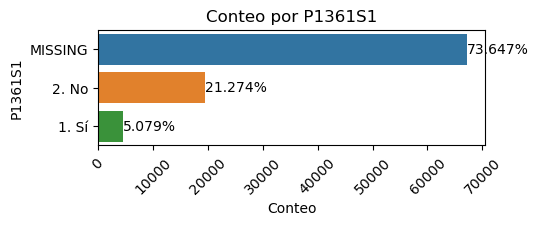

count     24040
unique        2
top         2.0
freq      20097
Name: P1361S15, dtype: object


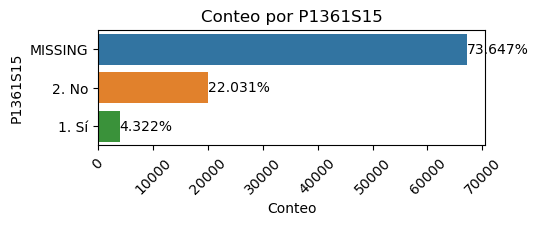

count     24040
unique        2
top         2.0
freq      22721
Name: P1361S14, dtype: object


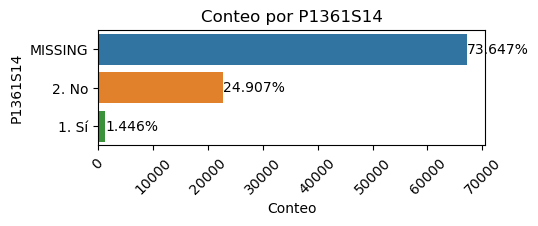

count     24040
unique        2
top         2.0
freq      13380
Name: P1361S2, dtype: object


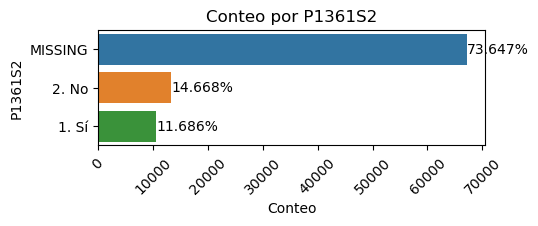

count     24040
unique        2
top         1.0
freq      13899
Name: P1361S16, dtype: object


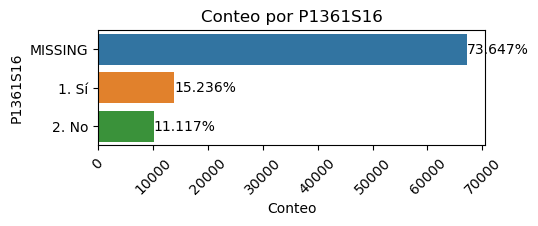

count     24040
unique        2
top         1.0
freq      16560
Name: P1361S3, dtype: object


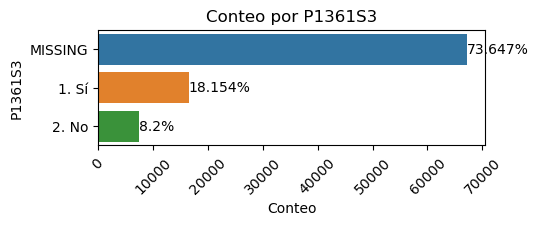

count     24040
unique        2
top         1.0
freq      20253
Name: P1361S4, dtype: object


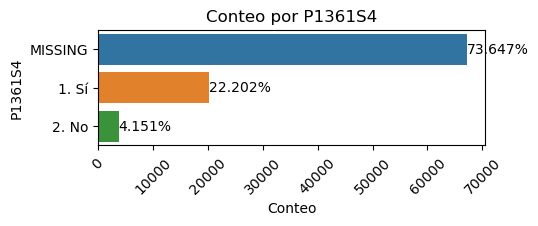

count     24040
unique        2
top         1.0
freq      13567
Name: P1361S5, dtype: object


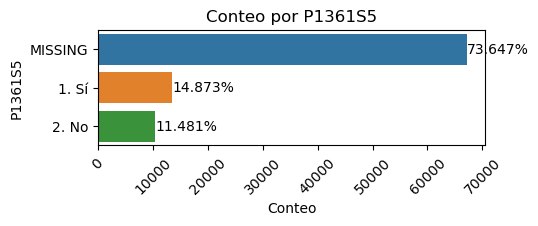

count     24040
unique        2
top         2.0
freq      13578
Name: P1361S6, dtype: object


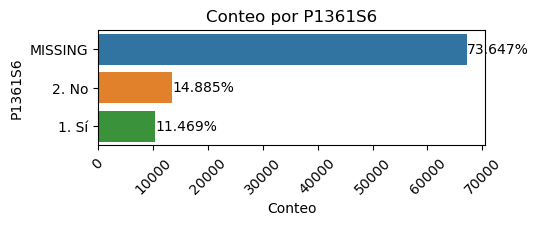

count     24040
unique        2
top         1.0
freq      13427
Name: P1361S7, dtype: object


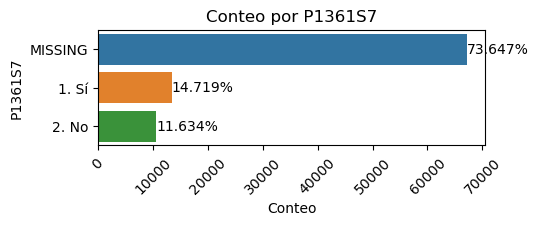

count     24040
unique        2
top         1.0
freq      12543
Name: P1361S11, dtype: object


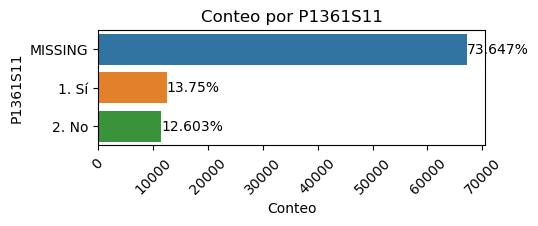

count     24040
unique        2
top         2.0
freq      19641
Name: P1361S8, dtype: object


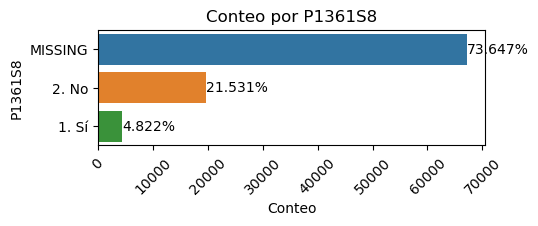

count     24040
unique        2
top         2.0
freq      23306
Name: P1361S9, dtype: object


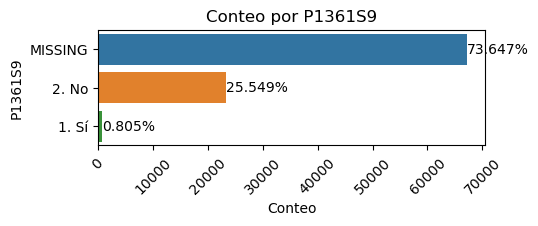

count     24040
unique        2
top         2.0
freq      22475
Name: P1361S10, dtype: object


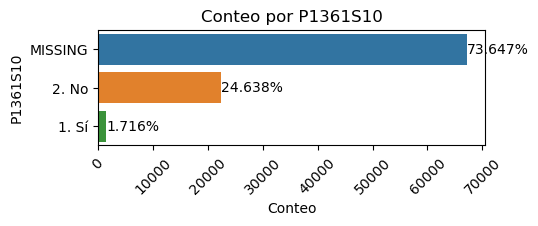

count     1083
unique       2
top        2.0
freq      1021
Name: P1361S12, dtype: object


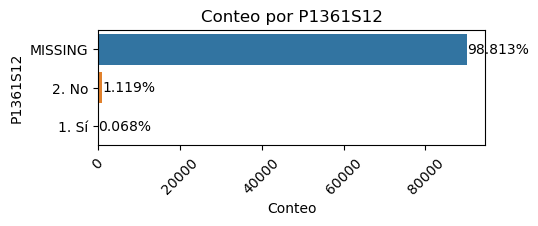

count     1083
unique       2
top        2.0
freq      1036
Name: P1361S13, dtype: object


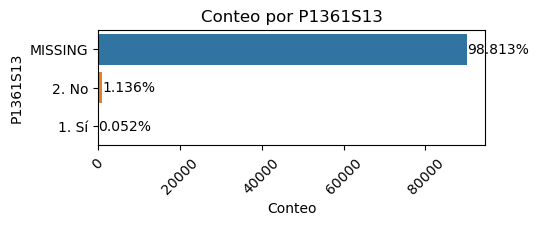

In [46]:
display(HTML(f"<h2>Análisis para grupo de variables \"se siente inseguro en barrio porque\"</h2>"))
descriptivo_grupo(df_base,vars_inseguro_barrio)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [47]:
vars_naturaleza['vars_agrupadas'].extend(vars_inseguro_barrio)
df_base['inseguro_barrio'] = df_base[vars_inseguro_barrio].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_inseguro_barrio] = df_base[vars_inseguro_barrio].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["inseguro_barrio"])
vars_naturaleza['vars_binarias'].extend(vars_inseguro_barrio)

count     49598
unique        2
top         2.0
freq      40487
Name: P1358S1, dtype: object


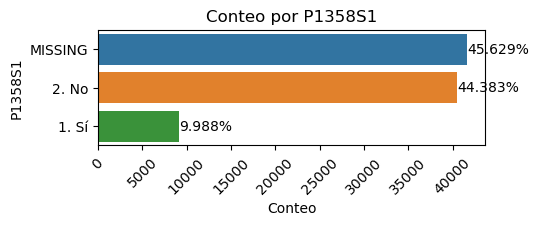

count     49598
unique        2
top         2.0
freq      41298
Name: P1358S14, dtype: object


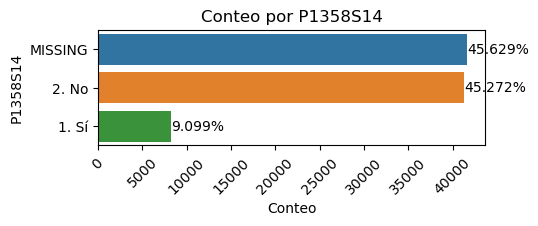

count     49598
unique        2
top         2.0
freq      46711
Name: P1358S13, dtype: object


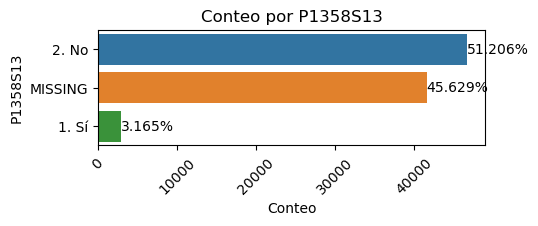

count     49598
unique        2
top         1.0
freq      33297
Name: P1358S2, dtype: object


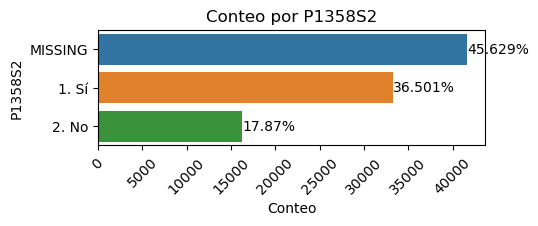

count     49598
unique        2
top         1.0
freq      34205
Name: P1358S15, dtype: object


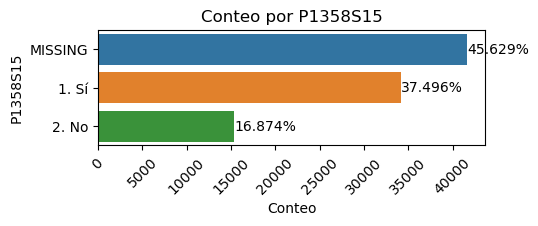

count     49598
unique        2
top         1.0
freq      33339
Name: P1358S3, dtype: object


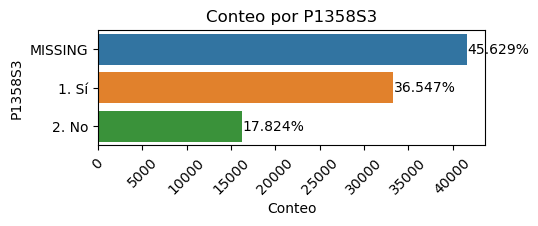

count     49598
unique        2
top         1.0
freq      41594
Name: P1358S4, dtype: object


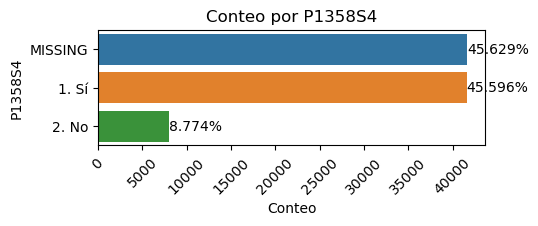

count     49598
unique        2
top         1.0
freq      31355
Name: P1358S5, dtype: object


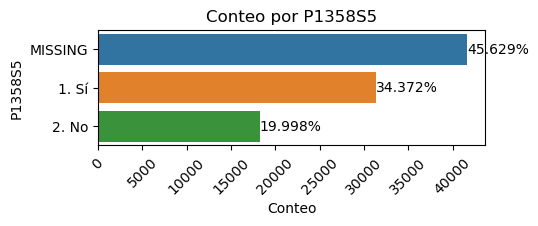

count     49598
unique        2
top         1.0
freq      24919
Name: P1358S6, dtype: object


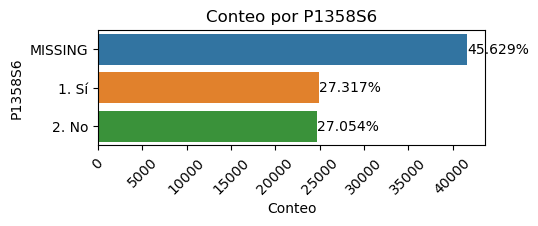

count     49598
unique        2
top         1.0
freq      30861
Name: P1358S7, dtype: object


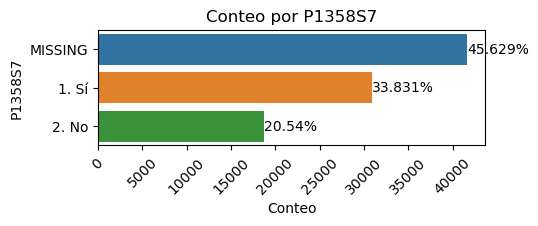

count     49598
unique        2
top         1.0
freq      27253
Name: P1358S12, dtype: object


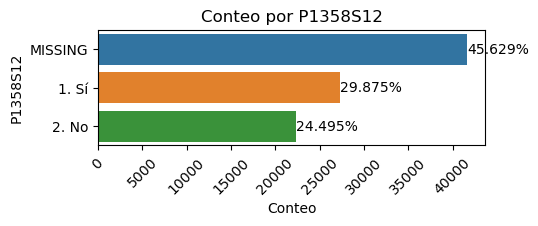

count     49598
unique        2
top         2.0
freq      36904
Name: P1358S8, dtype: object


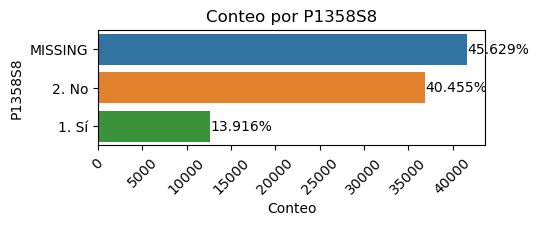

count     49598
unique        2
top         2.0
freq      46337
Name: P1358S9, dtype: object


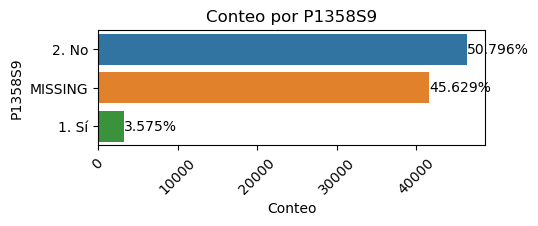

count     49598
unique        2
top         2.0
freq      43591
Name: P1358S11, dtype: object


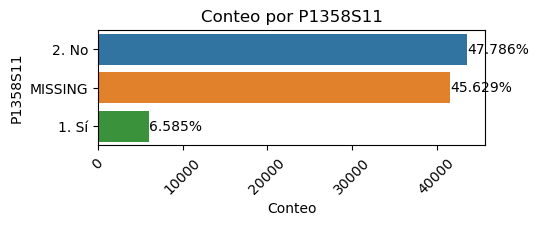

count     49598
unique        2
top         2.0
freq      28647
Name: P1358S10, dtype: object


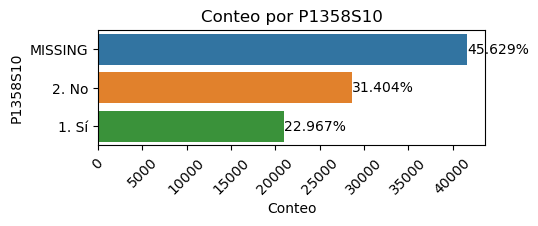

In [48]:
display(HTML(f"<h2>Análisis para grupo de variables \"se siente inseguro en ciudad porque\"</h2>"))
descriptivo_grupo(df_base,vars_inseguro_ciudad)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [49]:
vars_naturaleza['vars_agrupadas'].extend(vars_inseguro_ciudad)
df_base['inseguro_ciudad'] = df_base[vars_inseguro_ciudad].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_inseguro_ciudad] = df_base[vars_inseguro_ciudad].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["inseguro_ciudad"])
vars_naturaleza['vars_binarias'].extend(vars_inseguro_ciudad)

count     91222
unique        3
top         2.0
freq      81669
Name: P3302S1, dtype: object


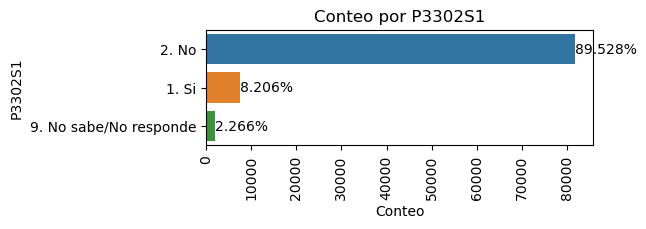

count     91222
unique        3
top         2.0
freq      84578
Name: P3302S2, dtype: object


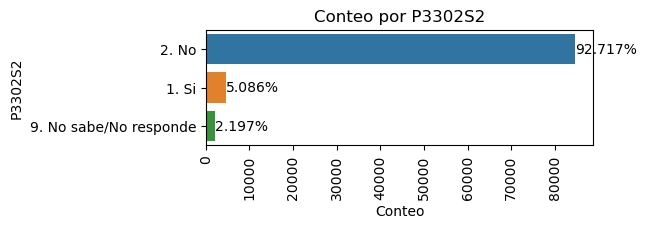

count     91222
unique        3
top         2.0
freq      88050
Name: P3302S3, dtype: object


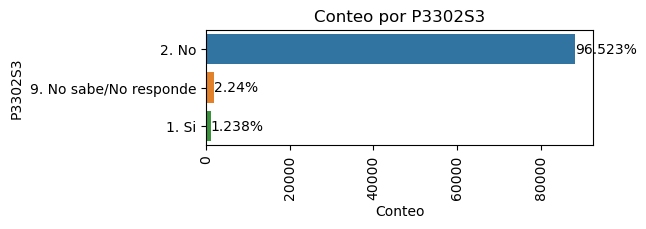

count     91222
unique        3
top         2.0
freq      88911
Name: P3302S4, dtype: object


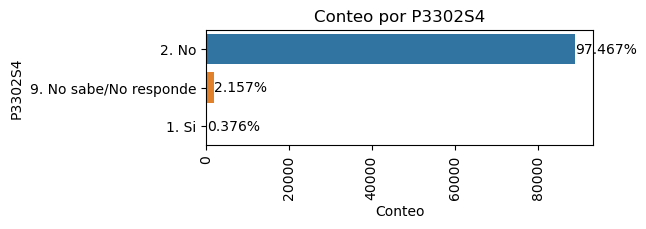

count     91222
unique        3
top         2.0
freq      88785
Name: P3302S5, dtype: object


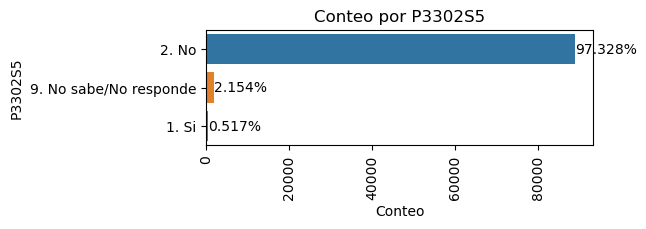

count     91222
unique        3
top         2.0
freq      89169
Name: P3302S6, dtype: object


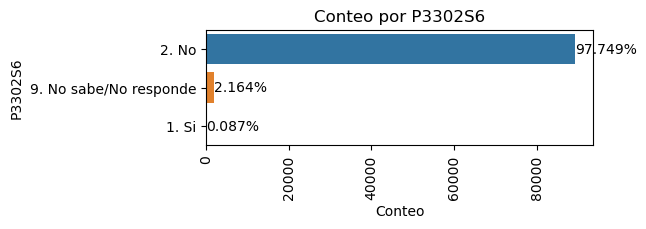

count     91222
unique        3
top         2.0
freq      88739
Name: P3302S7, dtype: object


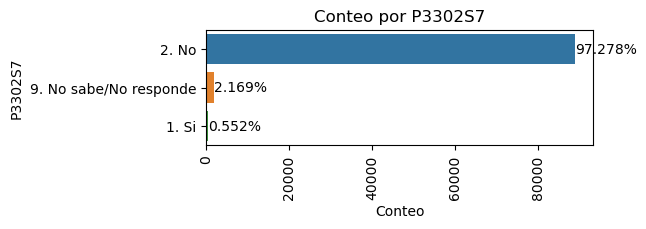

count     91222
unique        3
top         2.0
freq      88972
Name: P3302S8, dtype: object


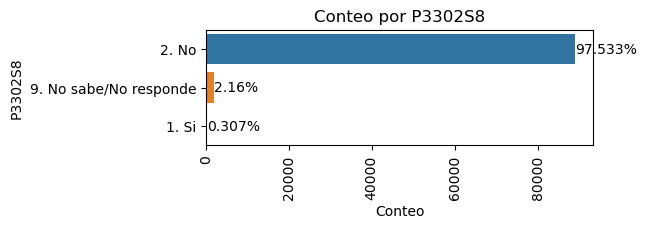

In [50]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha experimentado situación incómoda\"</h2>"))
descriptivo_grupo(df_base,vars_ha_expe_incomoda)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [51]:
vars_naturaleza['vars_agrupadas'].extend(vars_ha_expe_incomoda)
df_base['ha_expe_incomoda'] = df_base[vars_ha_expe_incomoda].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_ha_expe_incomoda] = df_base[vars_ha_expe_incomoda].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["ha_expe_incomoda"])
vars_naturaleza['vars_binarias'].extend(vars_ha_expe_incomoda)

count     70285
unique        2
top         2.0
freq      70046
Name: P3306, dtype: object


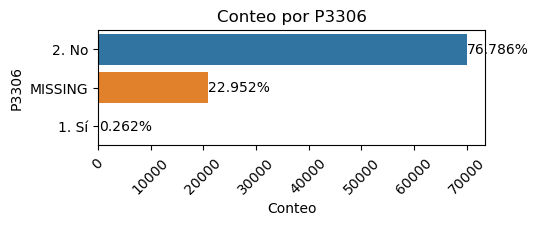

count     70285
unique        2
top         2.0
freq      69731
Name: P3307, dtype: object


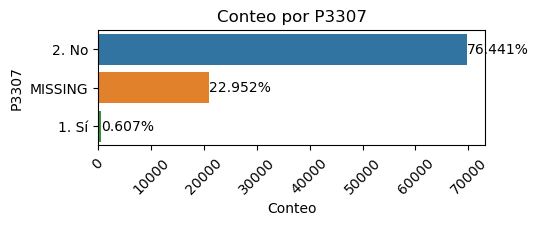

count     70285
unique        2
top         2.0
freq      70084
Name: P3308, dtype: object


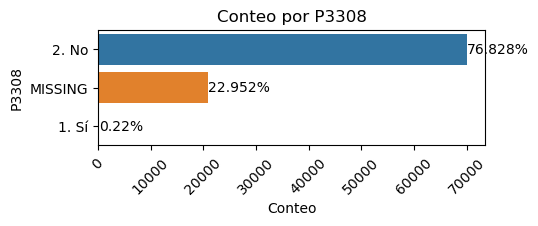

count     70285
unique        2
top         2.0
freq      70032
Name: P3309, dtype: object


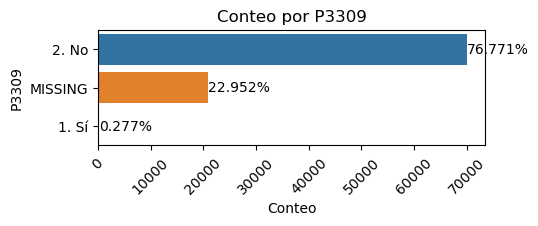

count     70285
unique        2
top         2.0
freq      70237
Name: P33010, dtype: object


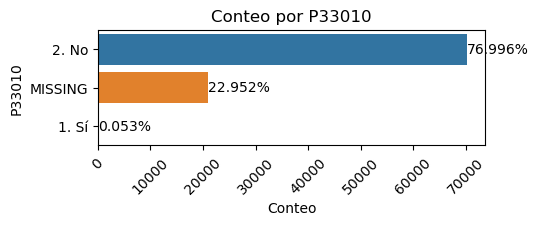

count     70285
unique        2
top         2.0
freq      69890
Name: P33011, dtype: object


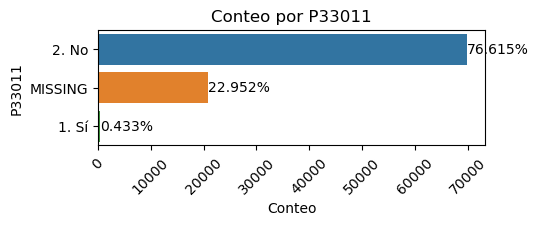

count     70285
unique        2
top         2.0
freq      70264
Name: P3312, dtype: object


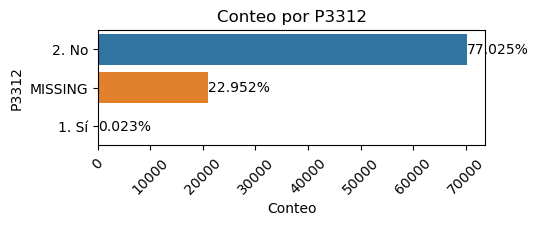

In [52]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha experimentado situación inseguridad\"</h2>"))
descriptivo_grupo(df_base,vars_ha_expe_situa)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [53]:
vars_naturaleza['vars_agrupadas'].extend(vars_ha_expe_situa)
df_base['ha_expe_situa'] = df_base[vars_ha_expe_situa].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_ha_expe_situa] = df_base[vars_ha_expe_situa].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["ha_expe_situa"])
vars_naturaleza['vars_binarias'].extend(vars_ha_expe_situa)

count     17154
unique        1
top         1.0
freq      17154
Name: P3112S1, dtype: object


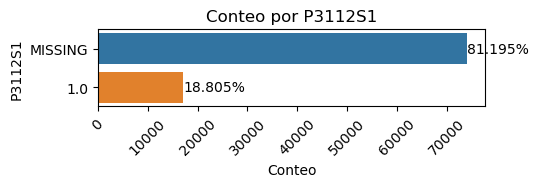

count     22752
unique        1
top         1.0
freq      22752
Name: P3112S2, dtype: object


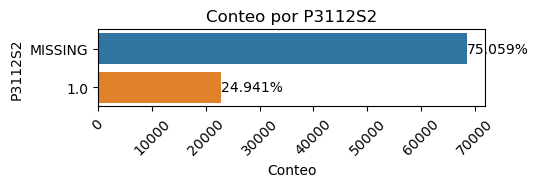

count     11273
unique        1
top         1.0
freq      11273
Name: P3112S3, dtype: object


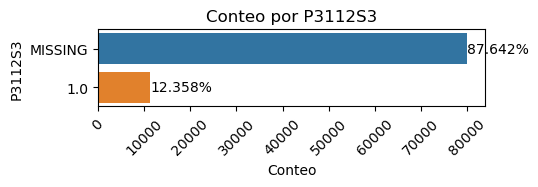

count     18012
unique        1
top         1.0
freq      18012
Name: P3112S4, dtype: object


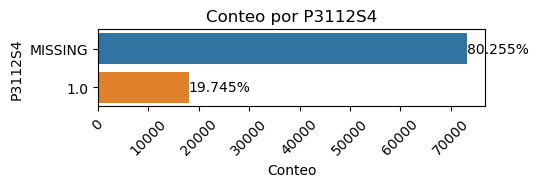

count     27946
unique        1
top         1.0
freq      27946
Name: P3112S5, dtype: object


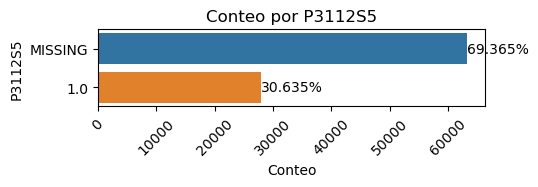

count     27386
unique        1
top         1.0
freq      27386
Name: P3112S6, dtype: object


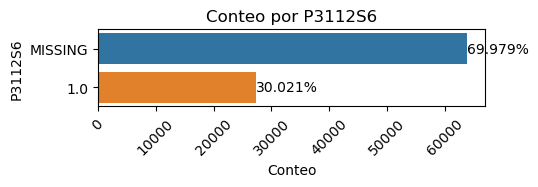

count     3137
unique       1
top        1.0
freq      3137
Name: P3112S7, dtype: object


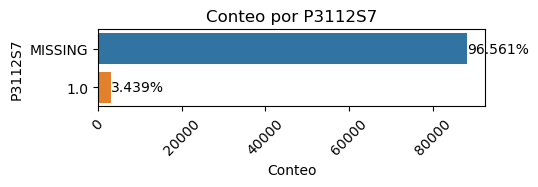

count     2042
unique       1
top        1.0
freq      2042
Name: P3112S8, dtype: object


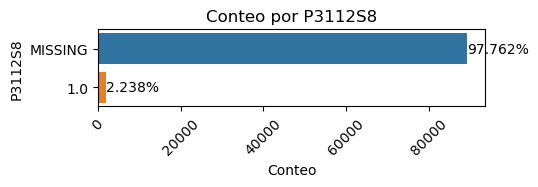

count     3376
unique       1
top        1.0
freq      3376
Name: P3112S9, dtype: object


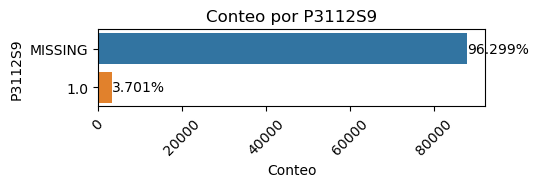

count     2279
unique       1
top        1.0
freq      2279
Name: P3112S10, dtype: object


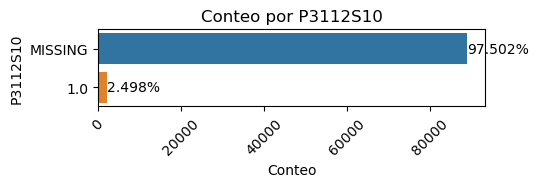

count     1817
unique       1
top        1.0
freq      1817
Name: P3112S11, dtype: object


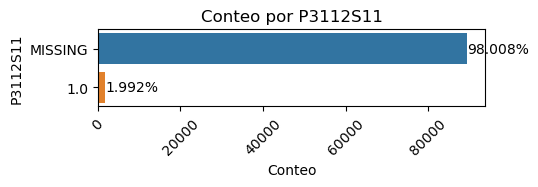

count     25994
unique        1
top         1.0
freq      25994
Name: P3112S12, dtype: object


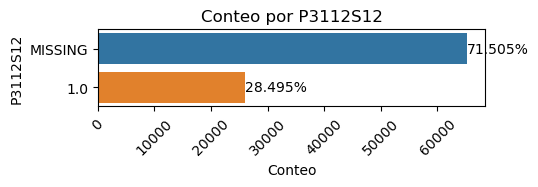

count     15717
unique        1
top         1.0
freq      15717
Name: P3112S13, dtype: object


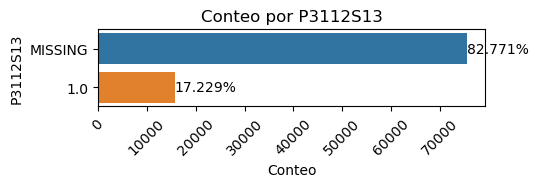

count     133
unique      1
top       1.0
freq      133
Name: P3112S14, dtype: object


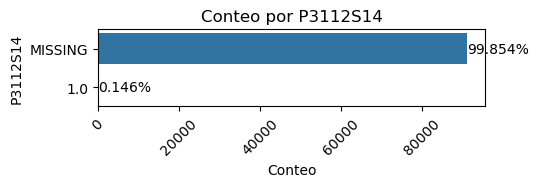

In [54]:
display(HTML(f"<h2>Análisis para grupo de variables \"ha tomado medidas\"</h2>"))
descriptivo_grupo(df_base,vars_tomo_medidas)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [55]:
vars_naturaleza['vars_agrupadas'].extend(vars_tomo_medidas)
df_base['tomo_medidas'] = df_base[vars_tomo_medidas].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_tomo_medidas] = df_base[vars_tomo_medidas].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["tomo_medidas"])
vars_naturaleza['vars_binarias'].extend(vars_tomo_medidas)

count     91222
unique        4
top         2.0
freq      63089
Name: P3105, dtype: object


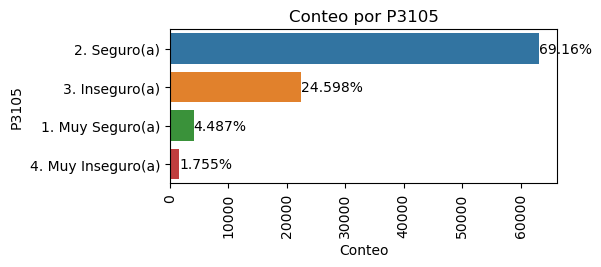

count     91222
unique        5
top         2.0
freq      41305
Name: P3106, dtype: object


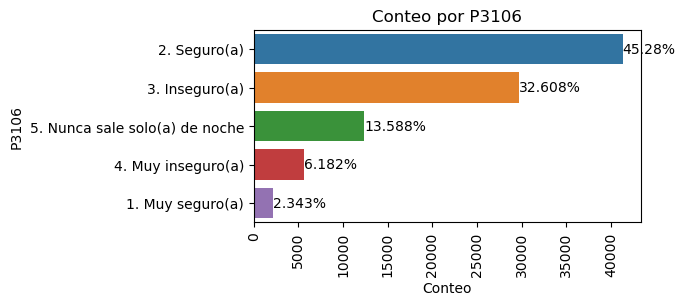

count     91222
unique        5
top         2.0
freq      64709
Name: P3502, dtype: object


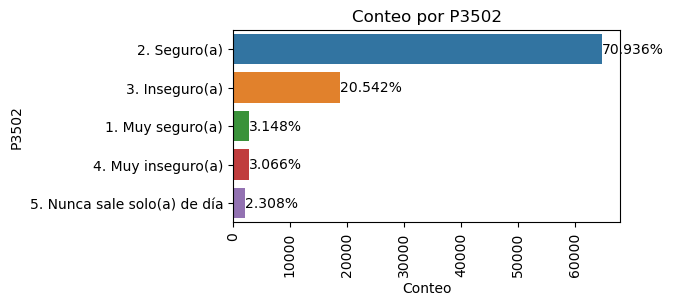

count     91222
unique        4
top         3.0
freq      43877
Name: P3107, dtype: object


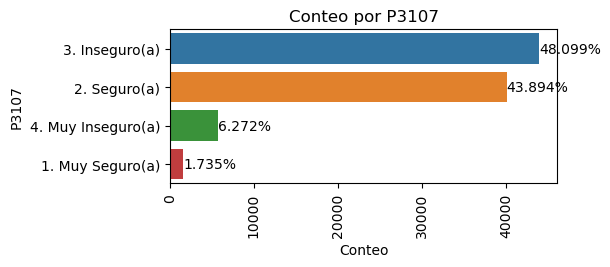

count     91222
unique        2
top         2.0
freq      66478
Name: P564, dtype: object


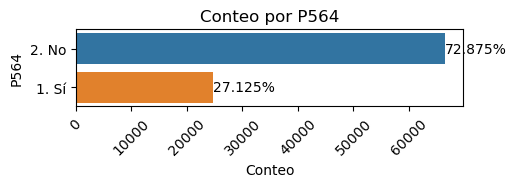

count     91222
unique        7
top         1.0
freq      41199
Name: P3114, dtype: object


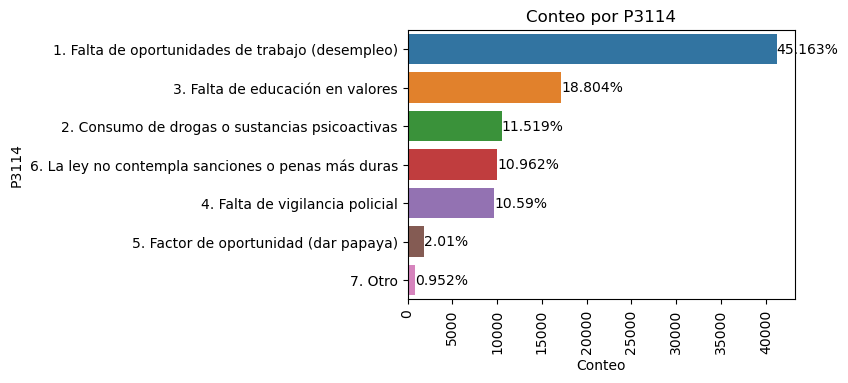

In [56]:
display(HTML(f"<h2>Análisis para grupo de variables \"sentimientos con respecto a seguridad\"</h2>"))
descriptivo_grupo(df_base,vars_siente)

In [57]:
vars_naturaleza['vars_discretas'].extend(["P3114"])
vars_naturaleza['vars_ordinales'].extend(["P3105","P3106","P3502","P3107"])
vars_naturaleza['vars_binarias'].extend(["P564"])

In [58]:
dict_P3114 = {'1.0': 'Falta oportunidades trabajo',
              '2.0': 'Consumo de drogas o sustancias',
              '3.0': 'Falta de educación en valores',
              '4.0': 'Falta de vigilancia policial',
              '5.0': 'Factor de oportunidad',
              '6.0': 'Sanciones o penas no duras',
              '7.0': 'Otro'}

df_base['P3114'] = df_base['P3114'].map(dict_P3114)

In [59]:
dict_P564 = {'1.0': 'Si','2.0': 'No'}

df_base['P564'] = df_base['P564'].map(dict_P564)

count     91222
unique        4
top         2.0
freq      71221
Name: P3111S1, dtype: object


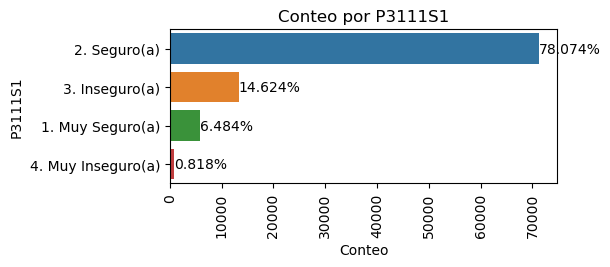

count     91222
unique        5
top         2.0
freq      36766
Name: P3111S2, dtype: object


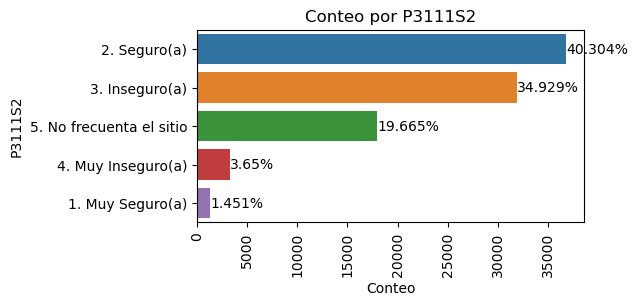

count     91222
unique        5
top         2.0
freq      37095
Name: P3111S3, dtype: object


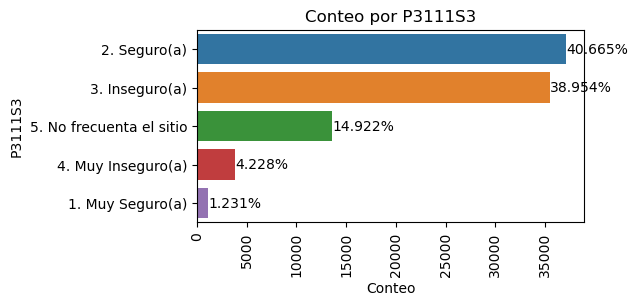

count     91222
unique        5
top         3.0
freq      36945
Name: P3111S4, dtype: object


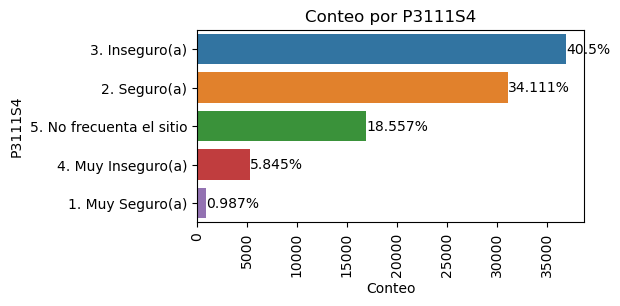

count     84561
unique        5
top         5.0
freq      32122
Name: P3111S5, dtype: object


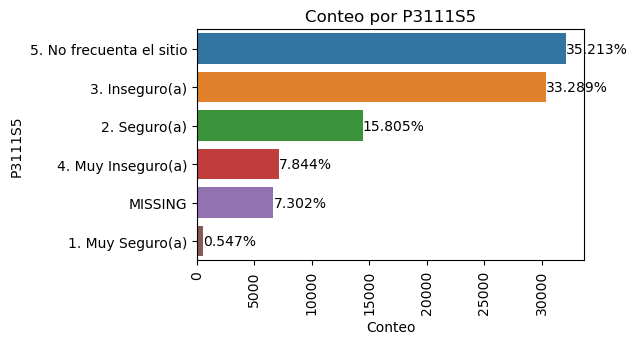

count     79342
unique        4
top         3.0
freq      46409
Name: P3111S6, dtype: object


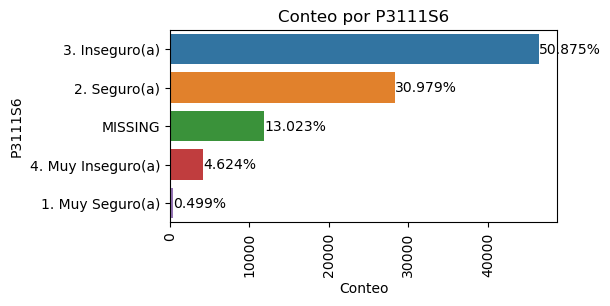

count     91222
unique        5
top         5.0
freq      42962
Name: P3111S8, dtype: object


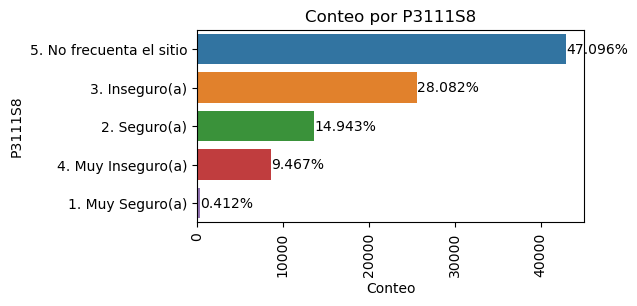

count     91222
unique        5
top         5.0
freq      48625
Name: P3111S9, dtype: object


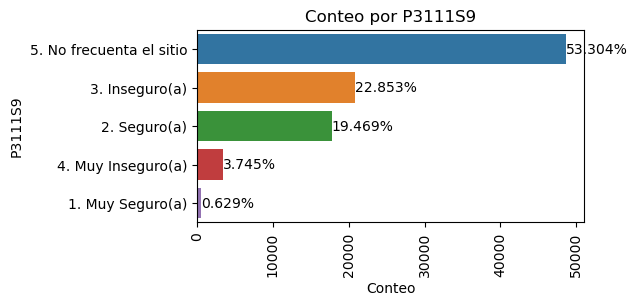

In [60]:
display(HTML(f"<h2>Análisis para grupo de variables \"seguridad en lugares\"</h2>"))
descriptivo_grupo(df_base,vars_segu_lugares)

De acuerdo a los valores de cada variable, se definieron que todas la variables de este grupo se tratarán como ordinales. Se asume que los missings corresponde a que no frecuenta el sitio (valor 5)

In [61]:
df_base[vars_segu_lugares] = df_base[vars_segu_lugares].astype(float).fillna(5)
vars_naturaleza['vars_ordinales'].extend(vars_segu_lugares)

count     5805
unique       1
top        1.0
freq      5805
Name: P3109S1, dtype: object


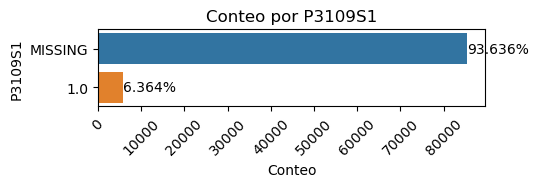

count     22534
unique        1
top         1.0
freq      22534
Name: P3109S2, dtype: object


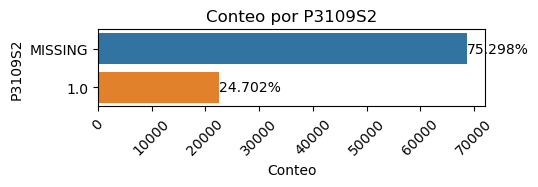

count     3628
unique       1
top        1.0
freq      3628
Name: P3109S3, dtype: object


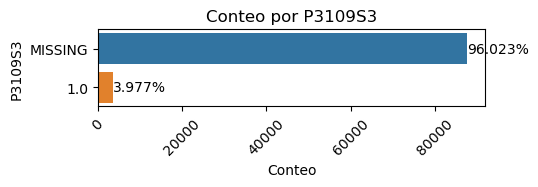

count     2115
unique       1
top        1.0
freq      2115
Name: P3109S4, dtype: object


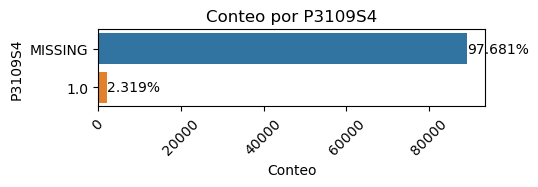

count     1277
unique       1
top        1.0
freq      1277
Name: P3109S5, dtype: object


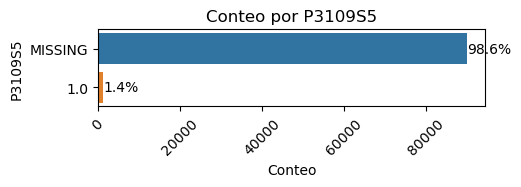

count     1885
unique       1
top        1.0
freq      1885
Name: P3109S6, dtype: object


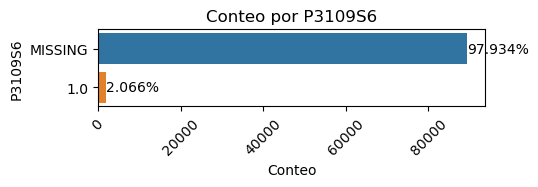

count     1374
unique       1
top        1.0
freq      1374
Name: P3109S7, dtype: object


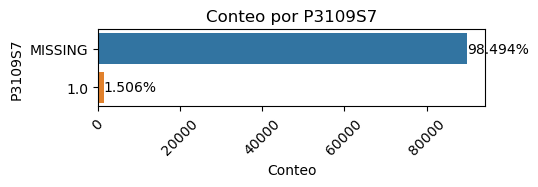

count     1119
unique       1
top        1.0
freq      1119
Name: P3109S16, dtype: object


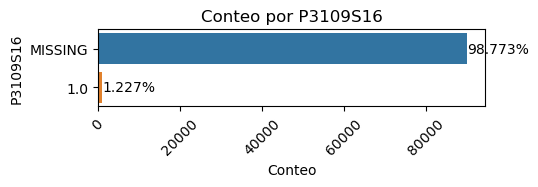

count     220
unique      1
top       1.0
freq      220
Name: P3109S17, dtype: object


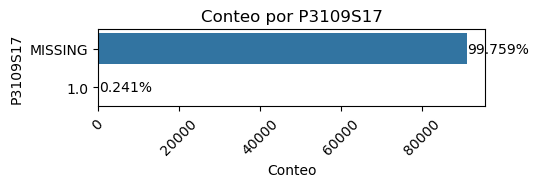

count     128
unique      1
top       1.0
freq      128
Name: P3109S9, dtype: object


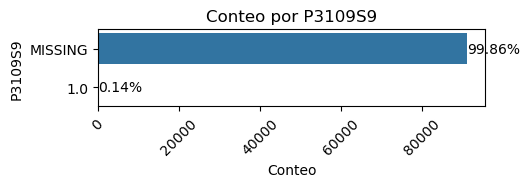

count     1629
unique       1
top        1.0
freq      1629
Name: P3109S10, dtype: object


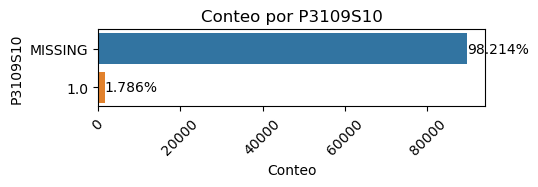

count     187
unique      1
top       1.0
freq      187
Name: P3109S11, dtype: object


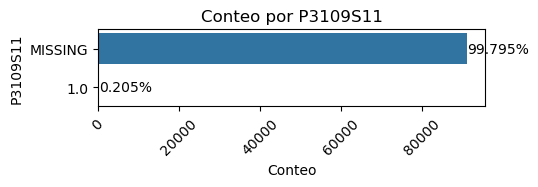

count      94
unique      1
top       1.0
freq       94
Name: P3109S12, dtype: object


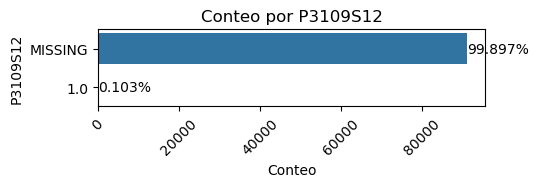

count      97
unique      1
top       1.0
freq       97
Name: P3109S13, dtype: object


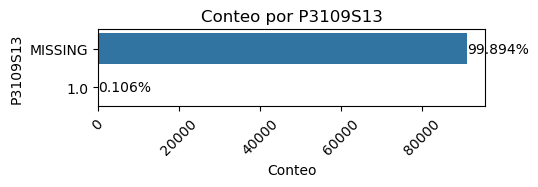

count     837
unique      1
top       1.0
freq      837
Name: P3109S18, dtype: object


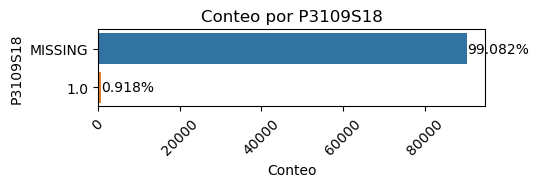

count      29
unique      1
top       1.0
freq       29
Name: P3109S14, dtype: object


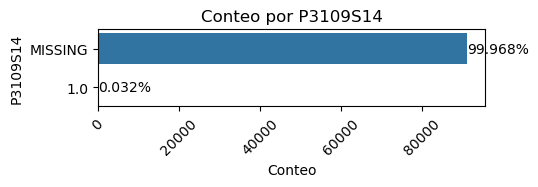

In [62]:
display(HTML(f"<h2>Análisis para grupo de variables \"cree será víctima\"</h2>"))
descriptivo_grupo(df_base,vars_sera_victima)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [63]:
vars_naturaleza['vars_agrupadas'].extend(vars_sera_victima)
df_base['sera_victima'] = df_base[vars_sera_victima].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_sera_victima] = df_base[vars_sera_victima].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["sera_victima"])
vars_naturaleza['vars_binarias'].extend(vars_sera_victima)

count     91222
unique        2
top         1.0
freq      46265
Name: P1353S1, dtype: object


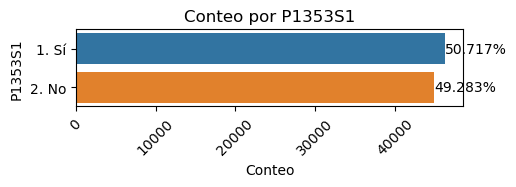

count     91222
unique        2
top         2.0
freq      77526
Name: P1353S2, dtype: object


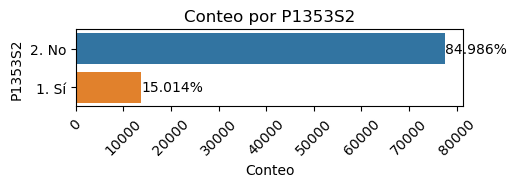

count     91222
unique        2
top         1.0
freq      54765
Name: P1353S3, dtype: object


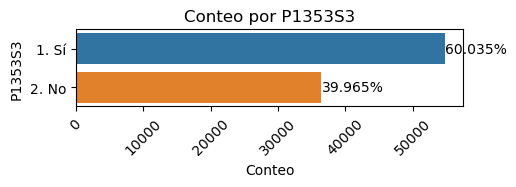

count     91222
unique        2
top         2.0
freq      88938
Name: P1353S4, dtype: object


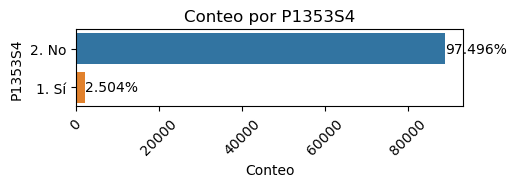

count     91222
unique        2
top         2.0
freq      85095
Name: P1353S5, dtype: object


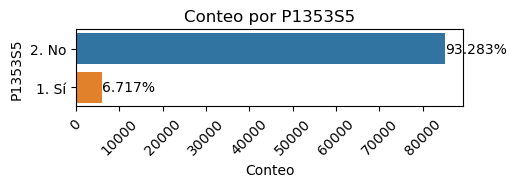

count     91222
unique        2
top         2.0
freq      70133
Name: P1353S6, dtype: object


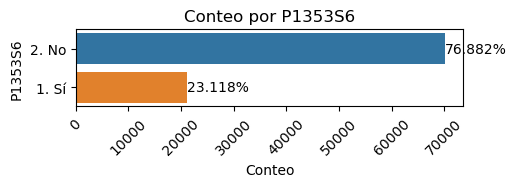

In [64]:
display(HTML(f"<h2>Análisis para grupo de variables \"justificaría violencia\"</h2>"))
descriptivo_grupo(df_base,vars_justi_violen)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [65]:
vars_naturaleza['vars_agrupadas'].extend(vars_justi_violen)
df_base['justi_violen'] = df_base[vars_justi_violen].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_justi_violen] = df_base[vars_justi_violen].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["justi_violen"])
vars_naturaleza['vars_binarias'].extend(vars_justi_violen)

count     91222
unique        4
top         3.0
freq      42292
Name: P3108, dtype: object


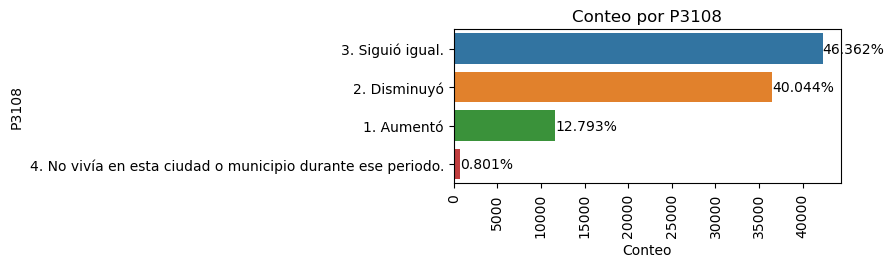

count     91222
unique        3
top         1.0
freq      38115
Name: P3113S1, dtype: object


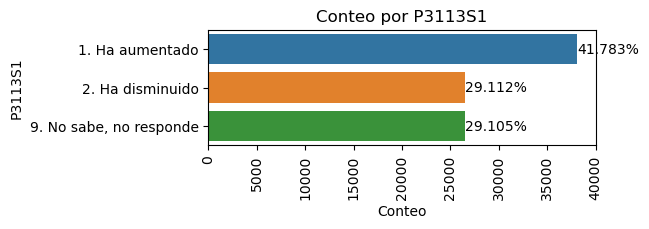

count     91222
unique        3
top         9.0
freq      51503
Name: P3113S3, dtype: object


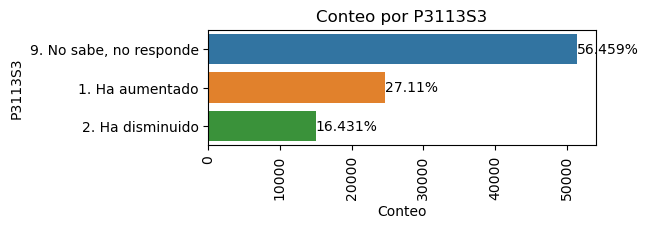

count     91222
unique        3
top         1.0
freq      36703
Name: P3113S4, dtype: object


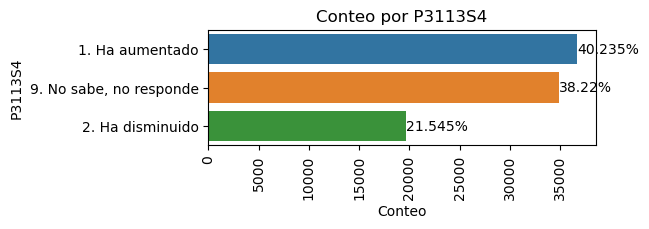

count     91222
unique        3
top         9.0
freq      72471
Name: P3113S5, dtype: object


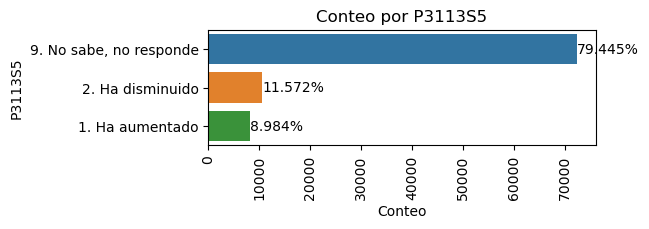

count     91222
unique        3
top         9.0
freq      77968
Name: P3113S6, dtype: object


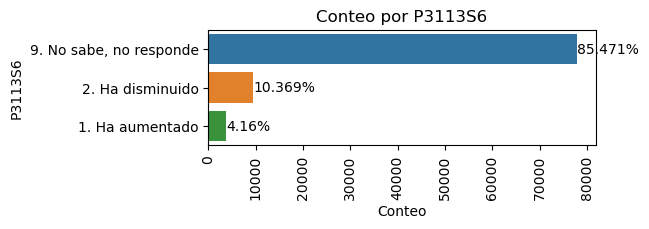

count     91222
unique        3
top         9.0
freq      71499
Name: P3113S7, dtype: object


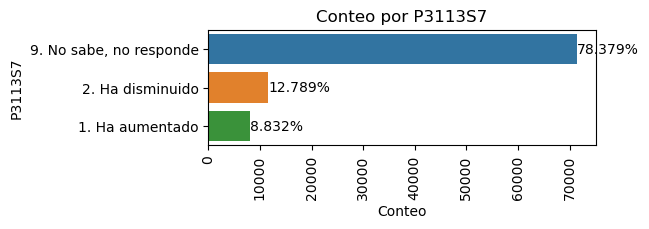

count     91222
unique        3
top         9.0
freq      49176
Name: P3113S8, dtype: object


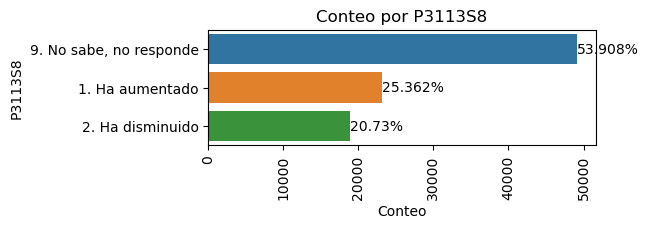

count     91222
unique        3
top         9.0
freq      56599
Name: P3113S9, dtype: object


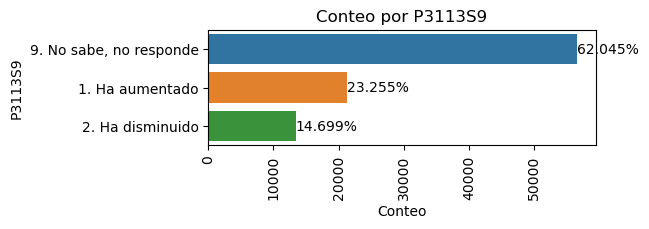

count     91222
unique        3
top         9.0
freq      40342
Name: P3113S10, dtype: object


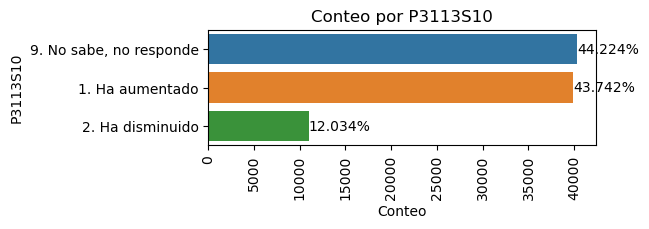

count     91222
unique        3
top         9.0
freq      54775
Name: P3113S20, dtype: object


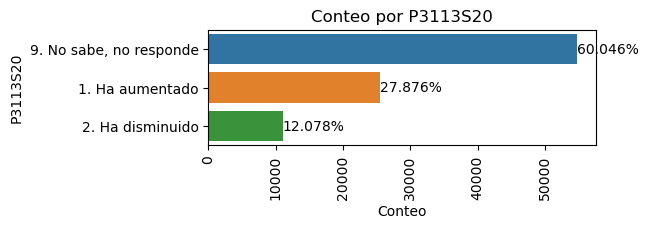

count     91222
unique        3
top         9.0
freq      58098
Name: P3113S21, dtype: object


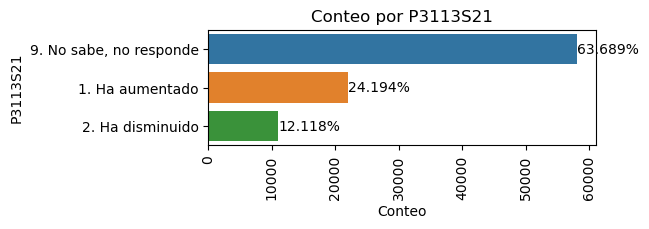

count     91222
unique        3
top         9.0
freq      57787
Name: P3113S22, dtype: object


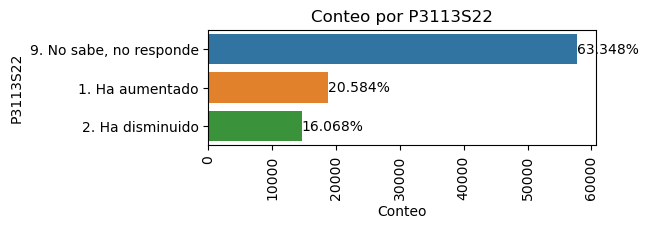

In [66]:
display(HTML(f"<h2>Análisis para grupo de variables \"percepción aumento o disminución situaciones\"</h2>"))
descriptivo_grupo(df_base,vars_percep)

Para este grupo de variables se identifican que son ordinales, sin embargo se cambiaría el orden de las clases.vars_naturaleza['vars_ordinales'].extend(vars_percep)

In [67]:
vars_naturaleza['vars_ordinales'].extend(vars_percep)

In [68]:
dict_P3108 = {'4.0': 0,
              '2.0': 1,
              '3.0': 2,
              '1.0': 3}
df_base['P3108'] = df_base['P3108'].map(dict_P3114)

In [69]:
dict_P3113 = {'9.0': 0,
              '2.0': 1,
              '1.0': 2}

for v in vars_percep:
    if v != 'P3108':
        df_base[v] = df_base[v].map(dict_P3113)

count     31738
unique        5
top         3.0
freq      14602
Name: P1612S1, dtype: object


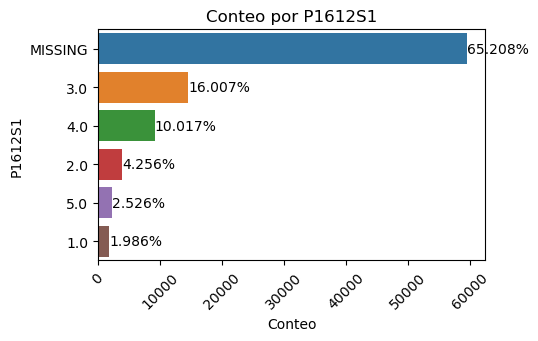

count     91222
unique        3
top         2.0
freq      56308
Name: P1182S1, dtype: object


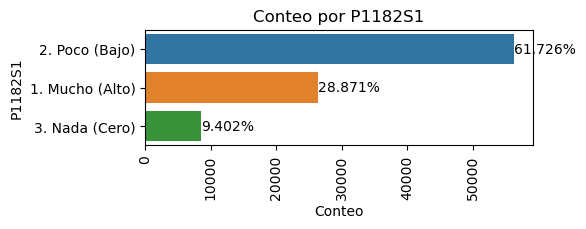

count     91222
unique        3
top         2.0
freq      52954
Name: P1182S2, dtype: object


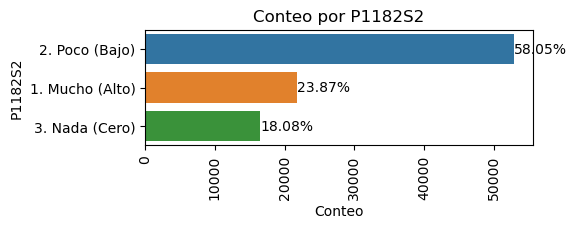

count     91222
unique        3
top         2.0
freq      53550
Name: P1182S3, dtype: object


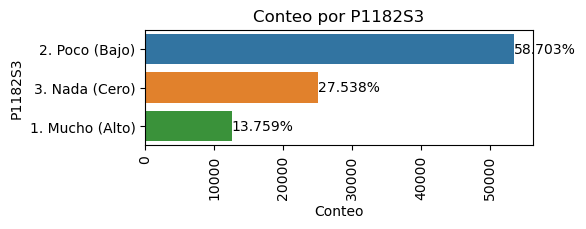

count     91222
unique        3
top         2.0
freq      53517
Name: P1181S1, dtype: object


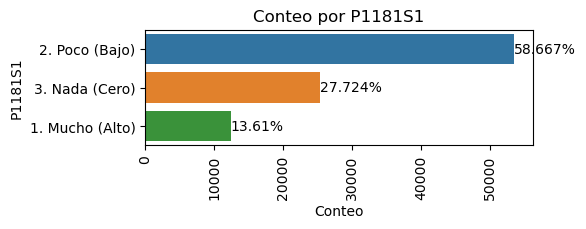

count     91222
unique        3
top         2.0
freq      51518
Name: P1181S2, dtype: object


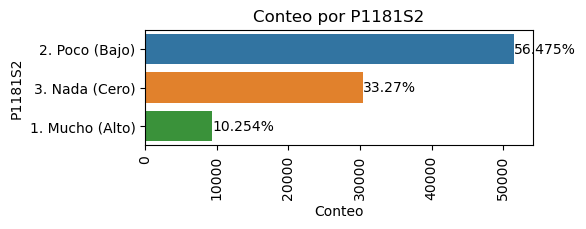

count     91222
unique        3
top         2.0
freq      52144
Name: P3317S1, dtype: object


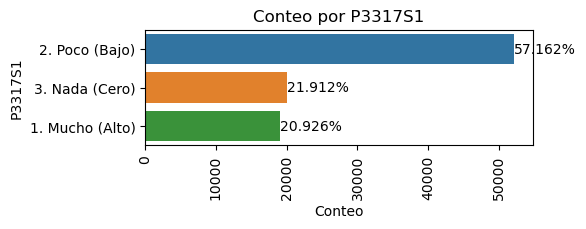

count     91222
unique        3
top         2.0
freq      54968
Name: P3317S2, dtype: object


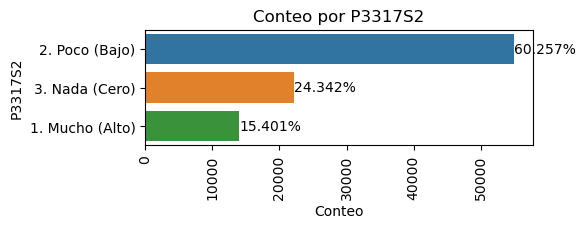

count     91222
unique        3
top         2.0
freq      54413
Name: P3317S3, dtype: object


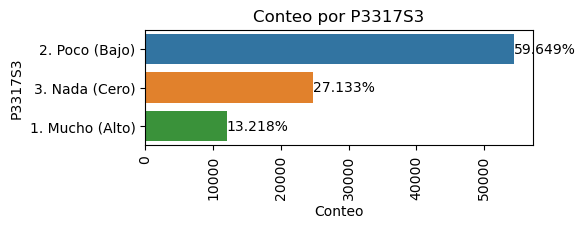

count     91222
unique        5
top         3.0
freq      46429
Name: P3321, dtype: object


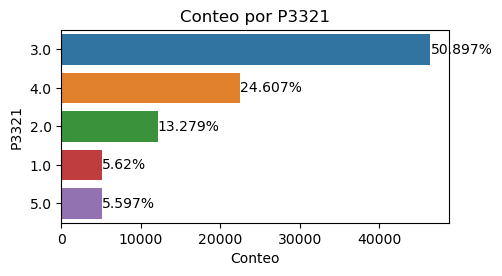

count     91222
unique        5
top         3.0
freq      40898
Name: P3119, dtype: object


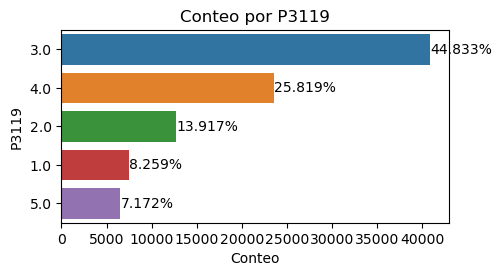

count     91222
unique        5
top         3.0
freq      47999
Name: P3127, dtype: object


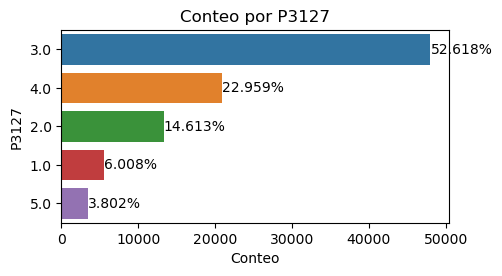

In [70]:
display(HTML(f"<h2>Análisis para grupo de variables \"confianza instituciones\"</h2>"))
descriptivo_grupo(df_base,vars_institu)

De acuerdo a los valores de cada variable, se definieron que todas la variables de este grupo se tratarán como ordinales

In [71]:
vars_naturaleza['vars_ordinales'].extend(vars_institu)

df_base[vars_institu] = df_base[vars_institu].fillna('0.0').astype(float)

count     55753
unique        1
top         1.0
freq      55753
Name: P3316S1, dtype: object


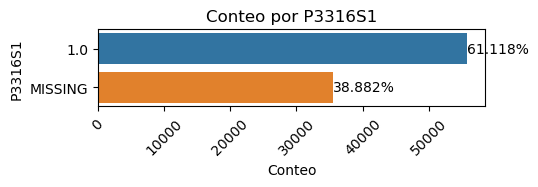

count     35178
unique        1
top         1.0
freq      35178
Name: P3316S2, dtype: object


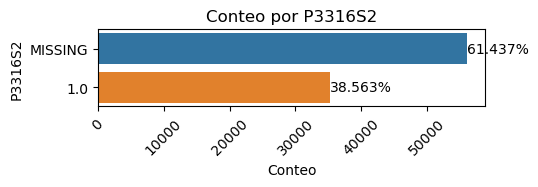

count     63132
unique        1
top         1.0
freq      63132
Name: P3316S3, dtype: object


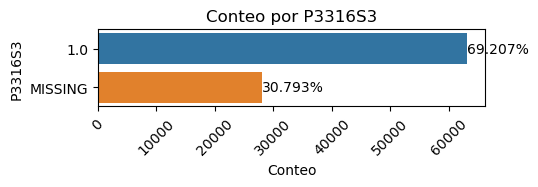

count     34629
unique        1
top         1.0
freq      34629
Name: P3316S4, dtype: object


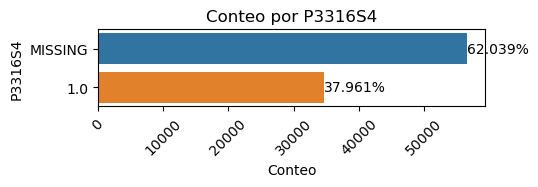

count     42835
unique        1
top         1.0
freq      42835
Name: P3316S5, dtype: object


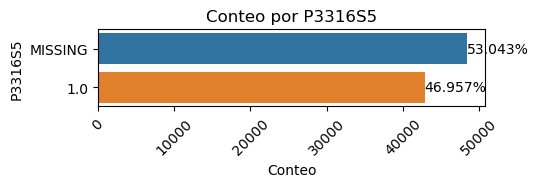

count     32841
unique        1
top         1.0
freq      32841
Name: P3316S6, dtype: object


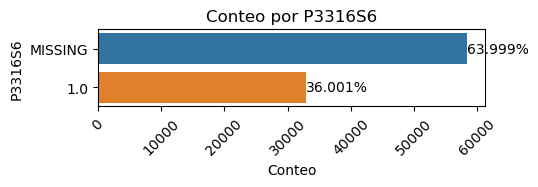

count     26958
unique        1
top         1.0
freq      26958
Name: P3316S7, dtype: object


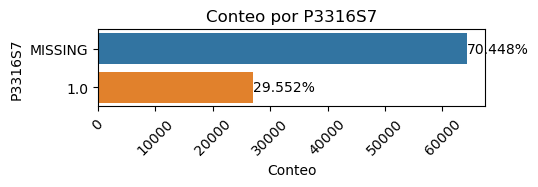

count     27127
unique        1
top         1.0
freq      27127
Name: P3316S8, dtype: object


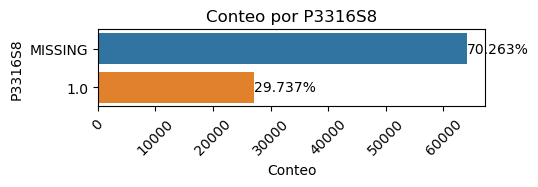

count     18459
unique        1
top         1.0
freq      18459
Name: P3316S9, dtype: object


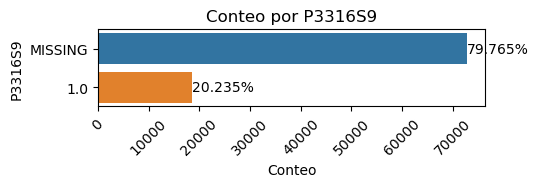

count     29078
unique        1
top         1.0
freq      29078
Name: P3316S10, dtype: object


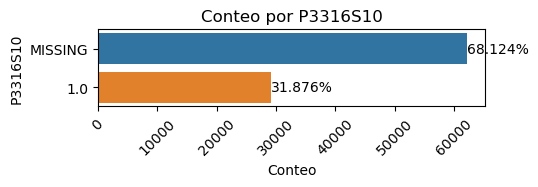

count     19046
unique        1
top         1.0
freq      19046
Name: P3316S11, dtype: object


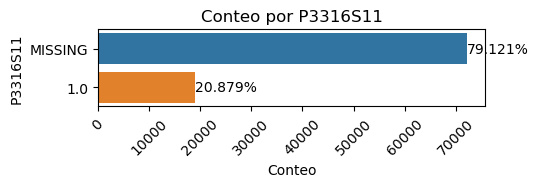

count     14321
unique        1
top         1.0
freq      14321
Name: P3316S12, dtype: object


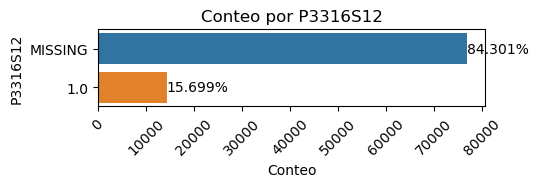

In [72]:
display(HTML(f"<h2>Análisis para grupo de variables \"qué mejoraría\"</h2>"))
descriptivo_grupo(df_base,vars_mejoraria)

De acuerdo a los valores de cada variable, se identificaron todas las variables de este grupo como binarias, sin embargo, debido a que hay altas concentraciones en el No generando así datos muy dispersos y con poca variación, decidimos cambiar el sentido de las variables y generar una sola variable para el grupo, donde se cuente con cuántas variables para este grupo respondió "Si". Así mismo se asumirán que los nulos, respuesta "2" que corresponde a "NO" y respuesta "9" que corresponde a dato faltante o no respondido, se asignarán con valor de 0 para los respectivos conteos.

In [73]:
vars_naturaleza['vars_agrupadas'].extend(vars_mejoraria)
df_base['mejoraria'] = df_base[vars_mejoraria].astype(float).fillna(0).replace(2,0).replace(9,0).sum(axis=1)
df_base[vars_mejoraria] = df_base[vars_mejoraria].fillna('0.0').replace('2.0','0.0').replace('9.0','0.0').replace("0.0","No").replace("1.0","Si")
vars_naturaleza['vars_numericas'].extend(["mejoraria"])
vars_naturaleza['vars_binarias'].extend(vars_mejoraria)

Validar contenido variables

In [74]:
for v in vars_naturaleza['vars_discretas']:
    print(v,dict_desc.get(v,""))
    print(df_base[v].value_counts(),"\n")

DEPMUNI Municipio
DESCONOCIDO       13027
CENTRO POBLADO    11880
BARRANQUILLA       6134
MONTERIA           5794
CARTAGENA          5753
CUCUTA             5160
BOGOTA             5114
BUCARAMANGA        4989
IBAGUE             4984
MEDELLIN           4877
VILLAVICENCIO      4855
PEREIRA            4780
MANIZALES          4771
CALI               4571
PASTO              4533
Name: DEPMUNI, dtype: int64 

P1987 1. Tipo de vivienda
Casa                 51587
Apartamento          38341
Cuarto (s)             954
Vivienda indígena      268
Otra vivienda           72
Name: P1987, dtype: int64 

P1989 3. La vivienda ocupada por este hogar es:
Propia                       49839
En arriendo o subarriendo    34328
En usufructo                  4910
Otra forma de tenencia        2145
Name: P1989, dtype: int64 

P1366 2. ... actualmente:
Está soltero(a)                            27945
No casado(a) vive pareja dos años o más    24312
Está casado(a)                             21726
Está separado(

In [75]:
for v in vars_naturaleza['vars_binarias']:
    print(v,dict_desc.get(v,""))
    print(df_base[v].value_counts(),"\n")

P220 3. Sexo
Mujer     49675
Hombre    41547
Name: P220, dtype: int64 

P565S1 a. Automóvil u otro automotor.
No    82155
Si     9067
Name: P565S1, dtype: Int64 

P565S2 b. Motocicleta.
No    80036
Si    11186
Name: P565S2, dtype: Int64 

P565S3 c. Bicicleta.
No    87616
Si     3606
Name: P565S3, dtype: Int64 

P565S4 d. Vehículo agrícola
No    91178
Si       44
Name: P565S4, dtype: Int64 

P3115S1 a. Lo(a) empujó o zarandeó
No    90740
Si      482
Name: P3115S1, dtype: Int64 

P3115S2 b. Lo(a) golpeó o agredió intencionalmente con una parte del cuerpo
No    90823
Si      399
Name: P3115S2, dtype: Int64 

P3115S3 c. Lo(a) golpeó intencionalmente con algún objeto o lo(a) agredió con algún tipo de arma (incluye disparos o puñaladas)
No    91058
Si      164
Name: P3115S3, dtype: Int64 

P1976S1 a. Fraude o estafa
No    90826
Si      396
Name: P1976S1, dtype: Int64 

P1976S2 b. Amenazas
No    90942
Si      280
Name: P1976S2, dtype: Int64 

P1976S9 c. Acoso laboral
No    91059
Si      163
N

In [76]:
for v in vars_naturaleza['vars_ordinales']:
    print(v,dict_desc.get(v,""))
    print(df_base[v].value_counts(),"\n")

P6210 1. ¿Cuál es el nivel educativo más alto alcanzado por ... y el último año o grado aprobado en este nivel?
5.0    31993
6.0    27845
3.0    18800
4.0     9639
1.0     2805
9.0      110
2.0       30
Name: P6210, dtype: Int64 

P1906S1 a. Oír la voz o los sonidos
4.0    87255
3.0     3044
2.0      794
1.0      129
Name: P1906S1, dtype: int64 

P1906S2 b. Hablar o conversar
4.0    89189
3.0     1413
2.0      447
1.0      173
Name: P1906S2, dtype: int64 

P1906S3 c. Ver de cerca, de lejos o alrededor
4.0    73478
3.0    15347
2.0     2291
1.0      106
Name: P1906S3, dtype: int64 

P1906S4 d. Mover el cuerpo, caminar o subir y bajar escaleras
4.0    83890
3.0     5252
2.0     1732
1.0      348
Name: P1906S4, dtype: int64 

P1906S5 e. Agarrar o mover objetos con las manos
4.0    87694
3.0     2598
2.0      798
1.0      132
Name: P1906S5, dtype: int64 

P1906S6 f. Entender, aprender, recordar o tomar decisiones por sí mismo(a)
4.0    88616
3.0     1778
2.0      553
1.0      275
Name: P19

Eliminar campos de identificación

In [77]:
df_base.drop(columns=["ORDEN","DIRECTORIO","SECUENCIA_ENCUESTA","SECUENCIA_P"],inplace=True,errors="ignore")

Veriricar nulos

In [78]:
(df_base.isna().sum()/len(df_base)).sort_values(ascending=False)

P220                0.0
P3316S4             0.0
P3113S7             0.0
P3113S8             0.0
P3113S9             0.0
P3113S10            0.0
P3113S20            0.0
P3113S21            0.0
P3113S22            0.0
P3114               0.0
P3316S1             0.0
P3316S2             0.0
P3316S3             0.0
P3316S5             0.0
P3113S5             0.0
P3316S6             0.0
P3316S7             0.0
P3316S8             0.0
P3316S9             0.0
P3316S10            0.0
P3316S11            0.0
P3316S12            0.0
P541                0.0
P1392               0.0
P1959               0.0
P1960               0.0
P3113S6             0.0
P3113S4             0.0
P565S2              0.0
P1353S5             0.0
P3112S8             0.0
P3112S9             0.0
P3112S10            0.0
P3112S11            0.0
P3112S12            0.0
P3112S13            0.0
P3112S14            0.0
P1353S1             0.0
P1353S2             0.0
P1353S3             0.0
P1353S4             0.0
P1353S6         

In [79]:
df_base.shape

(91222, 222)

Exportamos base

In [80]:
import pickle
pickle.dump(df_base, open("../results/df_base.pkl","wb"))
pickle.dump(vars_naturaleza, open("../results/vars_naturaleza.pkl","wb"))